OPTICAL FLOW

In [24]:
import cv2
import numpy as np

def square_center(x1, y1, x2, y2):
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    return int(cx), int(cy)

def detection_cv2(template, img, w, h):
    res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)

    threshold = 0.90
    loc = np.where( res >= threshold)
    # print("max", loc)
    

    bboxes = [[i, j, w, h] for i, j in zip(loc[0], loc[1])]
    scores = [res[i,j] for i, j in zip(loc[0], loc[1])]
    score_threshold = 0.92
    nms_threshold = 0.5
    # print(bboxes, scores)

    indices = cv2.dnn.NMSBoxes(bboxes, scores, score_threshold, nms_threshold)#top_k: if >0, keep at most top_k picked indices.
    # detections = [[bboxes[i][1], bboxes[i][0], bboxes[i][1] + w, bboxes[i][0] + h, scores[i]] for i in indices]
    detections = [square_center(bboxes[i][1], bboxes[i][0], bboxes[i][1] + w, bboxes[i][0] + h) for i in indices]
    return detections

def get_centroids(binary_image):
    # Set the kernel size for erosion
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply erosion to remove small clusters
    binary_image = cv2.erode(binary_image, kernel, iterations=1)

    _, labeled_image = cv2.connectedComponents(binary_image)
    centroids = []
    
    if np.max(labeled_image) == 0:
        return None
    
    for label in range(1, np.max(labeled_image) + 1):
        component_mask = (labeled_image == label).astype(np.uint8)
        m = cv2.moments(component_mask)
        
        if m["m00"] != 0:
            centroid_x = int(m["m10"] / m["m00"])
            centroid_y = int(m["m01"] / m["m00"])
            centroids.append((centroid_x, centroid_y))
    return centroids

def filter_MB_candidates(template, image, centroids):
    image_copy = image.copy()
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_GRAY2BGR)
    
    if centroids is None:
        return None
    
    w, h = template.shape[::-1]
    threshold = 0.0
    # Extract Regions of Interest (ROIs) around each centroid
    MB_candidates_centroids = []
    for centroid in centroids:
        cx, cy = centroid
        # Calculate the region of interest boundaries
        roi_x_start = max(0, cx - template.shape[1] // 2)
        roi_y_start = max(0, cy - template.shape[0] // 2)
        roi_x_end = min(image.shape[1], cx + template.shape[1] // 2)
        roi_y_end = min(image.shape[0], cy + template.shape[0] // 2)
        
        # Ensure the region of interest has the same size as the template
        roi_width = roi_x_end - roi_x_start
        roi_height = roi_y_end - roi_y_start
        
        # Adjust the ROI boundaries if needed
        if roi_width < template.shape[1]:
            half_diff = (template.shape[1] - roi_width) // 2
            roi_x_start = max(0, roi_x_start - half_diff)
            roi_x_end = min(image.shape[1], roi_x_end + half_diff)
        
        if roi_height < template.shape[0]:
            half_diff = (template.shape[0] - roi_height) // 2
            roi_y_start = max(0, roi_y_start - half_diff)
            roi_y_end = min(image.shape[0], roi_y_end + half_diff)
        
        # Extract the region around the centroid for correlation
        roi = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]
    
        # Apply Template Matching    
        correlation_result = cv2.matchTemplate(roi, template, cv2.TM_CCOEFF_NORMED)
        print(np.max(correlation_result))
        
        # cv2.rectangle(image_copy, (roi_x_start, roi_y_start), (roi_x_end, roi_y_end), (255, 0, 0), 1)
        # Check if the correlation score is above the threshold
        if np.max(correlation_result) > threshold:
            centroid = ((roi_x_end+roi_x_start)//2,(roi_y_end+roi_y_start)//2)
            MB_candidates_centroids.append(centroid)
            print(centroid, roi.shape[::-1], template.shape[::-1])
    # # Display the result
    # cv2.imshow('Matching Result', image_copy)
    # cv2.waitKey(0)
    # cv2.destroyWindow('Matching Result')
    return MB_candidates_centroids

In [342]:
import cv2
import numpy as np

# Open a video capture object
video_path = "Test videos/6th Setup Octogone without tube/0_6mL_min_real_unactuated_2/0_6mL_min_real_unactuated_2.avi"
video_path = "Test videos/6th Setup Octogone without tube/1_6mL_min_real_unactuated/1_6mL_min_real_unactuated.avi"
video_path = "Test videos/8th Setup Transducer Underneath/1_2mL_min_real_actuated_4MHz_2/1_2mL_min_real_actuated_4MHz_2.avi"
video_path = "Test videos/11th Setup Piezo 1Mhz Silicium/Side_on_off_ 18Vpp/Side_on_off_ 18Vpp.avi"
video_path = "Test videos/12th Setup Bifurcation/5_5_mL_min_Curved_2MHz_4Vpp/5_5_mL_min_Curved_2MHz_4Vpp.avi"
video_path = "Test videos/Lots of tests/MB diluted 2mL_min.avi"

cap = cv2.VideoCapture(video_path)
# Initialize template
template = cv2.imread("template/template2.png", cv2.IMREAD_GRAYSCALE)
w, h = template.shape[::-1]

# Parameters
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.1,
                       minDistance = 10,
                       blockSize = 10 )

# Read the first frame
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

while True:
    # Read the next frame
    ret, frame = cap.read()
    if not ret:
        break  # Break the loop if the video ends

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute the absolute difference between the current and previous frame
    frame_diff = cv2.absdiff(gray, prev_gray)
    
    # Threshold the difference to get binary motion mask
    _, motion_mask = cv2.threshold(frame_diff, 30, 255, cv2.THRESH_TOZERO)
    
    # Display the motion mask
    cv2.imshow('Motion Mask', motion_mask)
    
    # Detect key points
    key_points = motion_mask.copy()
    p0 = cv2.goodFeaturesToTrack(key_points, mask = None, **feature_params)
    key_points = cv2.cvtColor(key_points, cv2.COLOR_GRAY2BGR)
    if p0 is not None:
        for p in p0:
            cv2.circle(key_points, (int(p[0][0]),int(p[0][1])), 3, (0, 255, 0), -1)  # -1 fills the circle
    
    centroids = get_centroids(motion_mask)
    centroids_filtered = filter_MB_candidates(template, gray, centroids)
    original_image = gray.copy()
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    if centroids is not None:
        for centroid in centroids:
            cv2.circle(original_image, centroid, 2, (0, 0, 255), -1)  # Draw a circle at each centroid
            cv2.circle(key_points, centroid, 2, (0, 0, 255), -1)  # Draw a circle at each centroid
    if centroids_filtered is not None:
        for centroid in centroids_filtered:
            cx, cy = centroid
            cv2.rectangle(original_image, (cx-w//2, cy-h//2), (cx+w//2, cy+h//2), (255, 0, 0), 1)
            cv2.rectangle(key_points, (cx-w//2, cy-h//2), (cx+w//2, cy+h//2), (255, 0, 0), 1)
    
    # Display original image
    cv2.imshow("original image", original_image)
    cv2.imshow('Dots', key_points)
    
    # Update the previous frame for the next iteration
    # prev_gray = gray.copy()

    key = cv2.waitKey(0)
    if key == 2555904:  # Check for the right arrow key
        continue

    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


0.3827444
(1325, 919) (26, 12) (27, 13)
0.07100965
(1332, 919) (26, 12) (27, 13)
0.3469638
(1210, 920) (26, 12) (27, 13)
0.1356035
(1237, 923) (26, 12) (27, 13)
0.20960005
(1250, 923) (26, 12) (27, 13)
0.32799435
(1320, 922) (26, 12) (27, 13)
0.30450934
(1352, 923) (26, 12) (27, 13)
0.15147386
(1319, 926) (26, 12) (27, 13)
-0.08460962
0.27289748
(1338, 924) (26, 12) (27, 13)
0.18037039
(1344, 925) (26, 12) (27, 13)
0.23837194
(1356, 926) (26, 12) (27, 13)
0.067375265
(1234, 927) (26, 12) (27, 13)
0.061190117
(1337, 929) (26, 12) (27, 13)
-0.0060620587
0.18617378
(1349, 928) (26, 12) (27, 13)
0.12937222
(1251, 930) (26, 12) (27, 13)
0.4478943
(1204, 932) (26, 12) (27, 13)
0.3827444
(1325, 919) (26, 12) (27, 13)
0.07100965
(1332, 919) (26, 12) (27, 13)
0.34750843
(1210, 920) (26, 12) (27, 13)
0.13584456
(1237, 923) (26, 12) (27, 13)
0.21045579
(1250, 923) (26, 12) (27, 13)
0.32799435
(1320, 922) (26, 12) (27, 13)
0.30450934
(1352, 923) (26, 12) (27, 13)
0.15147386
(1319, 926) (26, 12) (2

In [ ]:
# Let's import essential modules
import numpy as np
import cv2
# Initialize template
template = cv2.imread("template/template2.png", cv2.IMREAD_GRAYSCALE)
w, h = template.shape[::-1]

# Initialise the video we want to work on
video_path = "Test videos/6th Setup Octogone without tube/1_6mL_min_real_unactuated/1_6mL_min_real_unactuated.avi"
video_path = "Test videos/8th Setup Transducer Underneath/1_2mL_min_real_actuated_4MHz_2/1_2mL_min_real_actuated_4MHz_2.avi"

cap = cv2.VideoCapture(video_path)

feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.1,
                       minDistance = 10,
                       blockSize = 10 )

lk_params = dict( winSize  = (10,10),
                  maxLevel = 1,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0,255,(100,3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
# p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# print("p0",p0)

# Use the template detection
p0 = detection_cv2(template, old_gray, w, h)
# print("p0_",p0)
# for p in p0:
#     cv2.circle(old_gray, p, 3, (0, 255, 0), -1)  # -1 fills the circle
# Display the image
# cv2.imshow('Dots', image_point)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
    
# Convert the list to a numpy array
points_array = np.array(p0, dtype=np.float32)
# Reshape the array to the required format
p0 = points_array.reshape(-1, 1, 2)
print("p0",p0)


# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(cap.isOpened()):
    ret,frame = cap.read()
    if ret:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
    # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)
        img = cv2.add(frame,mask)
        cv2.imshow('frame',img)
        cv2.setWindowProperty('frame', cv2.WND_PROP_TOPMOST, 1)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break
    # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
    else:
        break
cv2.destroyAllWindows()
cap.release()

BLOB DETECTION

In [ ]:
import cv2

# Create a VideoCapture object to capture video from a file or camera
video_path = "Test videos/8th Setup Transducer Underneath/1_2mL_min_real_actuated_4MHz_2/1_2mL_min_real_actuated_4MHz_2.avi"
cap = cv2.VideoCapture(video_path)

# Set up SimpleBlobDetector parameters
params = cv2.SimpleBlobDetector_Params()

# Change parameters as needed
params.minThreshold = 10
params.maxThreshold = 100
params.filterByArea = True
params.minArea = 5
params.maxArea = 1000
# params.filterByCircularity = True
# params.maxCircularity = 1
# params.minCircularity = 0.8
params.filterByConvexity = False
params.filterByInertia = True
# params.minInertiaRatio = 0.2
params.maxInertiaRatio = 1.5

# Create a SimpleBlobDetector with the specified parameters
detector = cv2.SimpleBlobDetector_create(params)

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Invert the grayscale image
    gray = 255 - gray

    # Detect blobs in the frame
    keypoints = detector.detect(gray)

    # Draw keypoints on the frame
    frame_with_keypoints = cv2.drawKeypoints(frame, keypoints, np.array([]), (0, 0, 255),
                                             cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Display the frame with keypoints
    cv2.imshow('Blob Detection', frame_with_keypoints)

    # Exit the loop if the user presses 'q'
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release the VideoCapture object and close the window
cap.release()
cv2.destroyAllWindows()


RETURN EVERY PATHS OF "frame_0000.png"

In [203]:
import os

def find_image_paths(root_dir):
    image_paths = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename == "frame_0000.png":
                image_paths.append(os.path.join(dirpath, filename))
    return image_paths

# Example usage:
root_directory = "Test videos"
image_paths = find_image_paths(root_directory)
print(len(image_paths))

if image_paths:
    for path in image_paths:
        print("Image found at:", path)
else:
    print("No images found.")



81
Image found at: Test videos\10th Setup Piezo 100kHz Glass\Side_on_off\frame_0000.png
Image found at: Test videos\11th Setup Piezo 1Mhz Silicium\1_8mL_min_20Vpp\frame_0000.png
Image found at: Test videos\11th Setup Piezo 1Mhz Silicium\Side_on_off_ 10Vpp\frame_0000.png
Image found at: Test videos\11th Setup Piezo 1Mhz Silicium\Side_on_off_ 14Vpp\frame_0000.png
Image found at: Test videos\11th Setup Piezo 1Mhz Silicium\Side_on_off_ 16Vpp\frame_0000.png
Image found at: Test videos\11th Setup Piezo 1Mhz Silicium\Side_on_off_ 18Vpp\frame_0000.png
Image found at: Test videos\11th Setup Piezo 1Mhz Silicium\Side_on_off_20Vpp\frame_0000.png
Image found at: Test videos\11th Setup Piezo 1Mhz Silicium\Side_on_off_20Vpp_2\frame_0000.png
Image found at: Test videos\12th Setup Bifurcation\1_2mL_min_1MHz_10Vpp\frame_0000.png
Image found at: Test videos\12th Setup Bifurcation\1_2mL_min_1MHz_15Vpp\frame_0000.png
Image found at: Test videos\12th Setup Bifurcation\2_2mL_min_1MHz_15Vpp\frame_0000.png
Ima

DETECT LINES

In [396]:
import cv2
import numpy as np

def find_best_lines(lines, contours, rho_threshold=10):
    best_lines = []

    for contour in contours:
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        # Calculate the distance of each line to the centroid
        distances = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            distance = abs((y2 - y1) * cx - (x2 - x1) * cy + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
            distances.append(distance)

        # Find the line with the minimum distance (best fit) for the contour
        min_distance_index = np.argmin(distances)
        best_lines.append(lines[min_distance_index][0])

    return best_lines

def find_intersection_points(image, lines):
    image_width = image.shape[1]
    intersection_points = []

    # Add left border as a line
    left_border = (0, 0, 0, image_width)
    lines.append(left_border)

    # Add right border as a line
    right_border = (image_width, 0, image_width, image_width)
    lines.append(right_border)

    for i in range(len(lines) - 1):
        for j in range(i + 1, len(lines)):
            line1 = lines[i]
            line2 = lines[j]

            # Extract coordinates
            x1, y1, x2, y2 = line1
            x3, y3, x4, y4 = line2

            # Calculate intersection point
            det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if det != 0:
                px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
                py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det
                intersection_points.append((px, py))

    return intersection_points

# def compute_center(points):
#     if not points:
#         return None

#     num_points = len(points)
#     sum_x = sum(point[0] for point in points)
#     sum_y = sum(point[1] for point in points)

#     center_x = int(sum_x / num_points)
#     center_y = int(sum_y / num_points)

#     return center_x, center_y

def compute_center(points, image):
    if not points:
        return None

    image_width, image_height = image.shape[1], image.shape[0]
    num_points = len(points)
    sum_x = sum(point[0] for point in points)
    sum_y = sum(point[1] for point in points)

    center_x = int(sum_x / num_points)
    center_y = int(sum_y / num_points)

    # Ensure the center coordinates are within the image boundaries
    center_x = max(0, min(center_x, image_width - 1))
    center_y = max(0, min(center_y, image_height - 1))

    return center_x, center_y

def detect_thick_white_lines(image_path, min_line_thickness=100, threshold_value=150):
    # Read the image in grayscale
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)[300:850, 650:1500]
    cap = cv2.VideoCapture(image_path)
    # Read the first frame
    ret, frame = cap.read()
    image = cv2.cvtColor(frame[300:850, 350:1250], cv2.COLOR_BGR2GRAY)
    # Threshold the image to obtain a binary image
    # _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = np.ones((5, 5), np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,5))

    opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=1)

    # Apply morphological closing to connect nearby white pixels
    kernel = np.ones((9, 9), np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (75,7))
    # kernel[0] = np.zeros(5)
    # kernel[4] = np.zeros(5)
    # kernel = np.ones((5, 10), np.uint8)
    # print(kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=8)
    # closing = cv2.dilate(opening, kernel, iterations=2)

    # Find contours in the binary image
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Find the contour with the largest area
        largest_contour = max(contours, key=cv2.contourArea)
    
    # Create a mask for the largest contour
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [largest_contour], 0, 255, thickness=cv2.FILLED)

    # Apply morphological operations for smoothing
    # kernel = np.ones((3, 3), np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
    
    smoothed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # smoothed_mask = cv2.morphologyEx(smoothed_mask, cv2.MORPH_OPEN, kernel)

    # Extract the region of interest (ROI) using the mask
    roi = cv2.bitwise_and(image, smoothed_mask)

    # # Draw thick lines on the original image
    # thick_lines_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # for contour in contours:
    #     # Filter contours based on area (thickness)
    #     if cv2.contourArea(contour) > min_line_thickness:
    #         cv2.drawContours(thick_lines_image, [contour], -1, (0, 0, 255), thickness=cv2.FILLED)

    #  # Convert the thick lines image to grayscale
    # # gray_thick_lines = cv2.cvtColor(closing, cv2.COLOR_BGR2GRAY)

    # # Apply HoughLinesP to detect lines
    # lines = cv2.HoughLinesP(closing, 1, np.pi/180, threshold=150, minLineLength=50, maxLineGap=5)

    # # Draw the detected lines on the original image
    # for line in lines:
    #     x1, y1, x2, y2 = line[0]
    #     cv2.line(thick_lines_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # # Find and draw the best lines for each contour
    # best_lines = find_best_lines(lines, contours)
    # for line in best_lines:
    #     x1, y1, x2, y2 = line
    #     cv2.line(thick_lines_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # # Find and draw the intersection points with the remaining lines
    # intersection_points = find_intersection_points(image, best_lines)
    # for point in intersection_points:
    #     cv2.circle(thick_lines_image, (int(point[0]), int(point[1])), 5, (0, 255, 255), -1)

    
    # center_point = compute_center(intersection_points, image)
    # cv2.circle(thick_lines_image, (center_point[0], center_point[1]), 5, (255, 255, 0), -1)

    ############### Display the original and result images ########################
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGRA)

    # Add transparency to the mask (convert to 4 channels - BGRA)
    transparent_mask = cv2.cvtColor(smoothed_mask, cv2.COLOR_GRAY2BGRA)

    # Set BGR color channels to red only where the mask is non-zero
    transparent_mask[:, :, :3] = np.where(transparent_mask[:, :, :3] > 0, [0, 0, 255], image[:, :, :3])
    transparent_mask[:, :, 3] = 100  # Set the alpha channel (transparency) value

    # Overlay the transparent mask on the original image
    image_roi = cv2.addWeighted(image, 1, transparent_mask, 0.5, 0)

    cv2.imshow("image + roi", image_roi)
    cv2.imshow("Original Image", image)
    # cv2.imshow("Thick White Lines", thick_lines_image)
    cv2.imshow("binary_image", binary_image)
    cv2.imshow("closing", closing)
    cv2.imshow("opening", opening)
    cv2.imshow("roi", roi)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage:
if __name__ == "__main__":
    image_path = "Test videos/14th Setup Bifurcation_2/1_5_mL_min_piezo_1MHz_10Vpp/frame_0002.png"
    image_path = "Test videos/12th Setup Bifurcation/Curved_2MHz/frame_0000.png"
    image_path = "Test videos/12th Setup Bifurcation/5_5_mL_min_Curved_2MHz/frame_0007.png"
    image_path = "Test videos/Lots of test 2 channels/2MHz Curved 15V 5mL_min.avi"
    image_path = "Test videos/Lots of tests/1MHz Silicium 10 15 20V 2mL_min.avi"
    detect_thick_white_lines(image_path)
    
    # root_directory = "Test videos"
    # image_paths = find_image_paths(root_directory)
    # for image_path in image_paths:
    #     print(image_path)
    #     detect_thick_white_lines(image_path)


In [220]:
import cv2
import numpy as np

def detect_lines(image, min_line_length=100):

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve edge detection
    # blurred = cv2.GaussianBlur(gray, (11, 11), 0)
    # cv2.imshow("blurred", blurred)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # # Use Canny edge detection
    # edges = cv2.Canny(blurred, 80, 150)

    # # Use Hough Line Transform to detect lines
    # lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=min_line_length, maxLineGap=10)

    # # Draw the lines on the original image
    # result_image = image.copy()
    # if lines is not None:
    #     for line in lines:
    #         x1, y1, x2, y2 = line[0]
    #         cv2.line(result_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    #############################################################
    # Create a LineSegmentDetector object
    lsd = cv2.createLineSegmentDetector(0)

    # Detect line segments
    lines, _, _, _ = lsd.detect(gray)
    # print(lines)
    # Draw the detected line segments on the original image
    result_image_3 = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = map(int, line[0])
            cv2.line(result_image_3, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Display the result
    # cv2.imshow("Detected Line Segments", result_image)

     # Filter out short lines
    # lines = [line[0] for line in lines if np.linalg.norm(np.array(line)) > 20]

    # Sort line segments by length in descending order
    lines = sorted(lines, key=lambda x: np.linalg.norm(np.array([x[0][0]-x[0][2], x[0][1]-x[0][3]])), reverse=True)

    # Select the top two longest line segments
    longest_segments = lines[:3]
    # print(np.linalg.norm(longest_segments[0][0]-longest_segments[0][1]))
    # print(longest_segments[0])
    # print([longest_segments[0][0]-longest_segments[0][2], longest_segments[0][1]-longest_segments[0][3]])

    # Draw the selected line segments on the original image
    # result_image_2 = image.copy()
    # for segment in longest_segments:
    #     x1, y1, x2, y2 = map(int, segment[0])
    #     cv2.line(result_image_2, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Create a mask
    mask = np.zeros_like(gray)
    points = []
    # Draw the selected line segments on the mask
    for seg in longest_segments:
        points.append([seg[0][0], seg[0][1]])
        points.append([seg[0][2], seg[0][3]])
    pts = np.array(points, dtype=np.int32)
    # print('pts', pts)

    # Sort the points in a clockwise order
    image_shape = image.shape
    pts = np.array(sorted(pts, key=lambda x: (np.arctan2(x[1]-image_shape[0]//2, x[0]-image_shape[1]//2)+2*np.pi)%(2*np.pi)))
    # print('pts', pts)

    cv2.fillConvexPoly(mask, pts, 255)

    # Apply the mask on the image
    result_image_4 = cv2.bitwise_and(gray, gray, mask=mask)

    # Display the result
    # cv2.imshow("mask applied", result_image_4)
    # cv2.imshow("mask", mask)
    cv2.imshow("Detected Line Segments", result_image_3)
    # cv2.imshow("Detected Line 2 longest Segments", result_image_2)
    # cv2.imshow("Detected Lines", result_image)
    # cv2.imshow("edges", edges)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return result_image_4

if __name__ == "__main__":
    image_path = "Test videos/12th Setup Bifurcation/5_5_mL_min_Curved_2MHz/frame_0007.png"
    # Read the image
    image = cv2.imread(image_path)[300:850, 650:1500]
    result_image = detect_lines(image)


In [42]:
import cv2
import numpy as np

# Open a video capture object
video_path = "Test videos/6th Setup Octogone without tube/0_6mL_min_real_unactuated_2/0_6mL_min_real_unactuated_2.avi"
video_path = "Test videos/6th Setup Octogone without tube/1_6mL_min_real_unactuated/1_6mL_min_real_unactuated.avi"
video_path = "Test videos/11th Setup Piezo 1Mhz Silicium/Side_on_off_ 18Vpp/Side_on_off_ 18Vpp.avi"
video_path = "Test videos/8th Setup Transducer Underneath/1_2mL_min_real_actuated_4MHz_2/1_2mL_min_real_actuated_4MHz_2.avi"

cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, prev_frame = cap.read()

while True:
    # Read the next frame
    ret, frame = cap.read()
    if not ret:
        break  # Break the loop if the video ends

    tube = detect_lines(frame)

    cv2.imshow("tube", tube)
    
    key = cv2.waitKey(0)
    if key == 2555904:  # Check for the right arrow key
        continue

    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break
    
# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


DETECT SCALE

In [362]:
import cv2
import numpy as np





def get_1cm_distance(frame, display = False):
    cv2.imwrite('Report/Images/original_image_detect_scale.png', frame)
    # Load the template image
    template1 = cv2.imread("template/Scale/1 dash.png", 0)  # Load as grayscale
    template2 = cv2.imread("template/Scale/2 dash.png", 0)  # Load as grayscale
    template_height1, template_width1 = template1.shape[::-1]
    template_height2, template_width2 = template2.shape[::-1]

    # Perform template matching
    result1 = cv2.matchTemplate(frame, template1, cv2.TM_CCOEFF_NORMED)
    result2 = cv2.matchTemplate(frame, template2, cv2.TM_CCOEFF_NORMED)

    # Find the location of the best match
    min_val1, max_val1, min_loc1, max_loc1 = cv2.minMaxLoc(result1)
    min_val2, max_val2, min_loc2, max_loc2 = cv2.minMaxLoc(result2)

    # Draw a rectangle around the best match
    top_left1 = max_loc1
    top_left2 = max_loc2
    if display:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        bottom_right1 = (top_left1[0] + template_height1, top_left1[1] + template_width1)
        cv2.rectangle(frame, top_left1, bottom_right1, (0, 255, 0), 1)
        bottom_right2 = (top_left2[0] + template_height2, top_left2[1] + template_width2)
        cv2.rectangle(frame, top_left2, bottom_right2, (0, 255, 0), 1)
        cv2.imwrite('Report/Images/template_matching_detect_scale.png', frame)
        cv2.line(frame, top_left1, top_left2, (0, 255, 255), 1)
        cv2.imwrite('Report/Images/line_detect_scale.png', frame)

        # Display the result
        cv2.imshow('Template Matching Result', frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return top_left2[1]-top_left1[1]

if __name__ == "__main__":
    # Load the main image
    video_path = "Test videos/Lots of tests/1MHz Silicium Top 10 15 20V 2mL_min.avi"
    video_path = "Test videos/Lots of test 2 channels/2MHz Curved Top 15V 5mL_min L.avi"
    video_path = "Test videos/Lots of tests 2/2Mhz Curved Square Top 6V 4_5mL_min L.avi"

    cap = cv2.VideoCapture(video_path)
    # Read the first frame
    ret, frame = cap.read()
    # Convert it to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    onecm = get_1cm_distance(frame, display=True)
    print("one cm corresponds to: ", onecm)



one cm corresponds to:  342


DETECT CROSS SECTION

In [357]:
import cv2
import numpy as np


def get_circles(frame, onecm):
    frame = frame[150:850, 300:1200]
#    cv2.imwrite('Report/Images/original_image_cross_section.png', frame)
    # Apply GaussianBlur to reduce noise
    gray_blur = cv2.GaussianBlur(frame, (9, 9), 0)
#    cv2.imwrite('Report/Images/blured_cross_section.png', gray_blur)
    # Use HoughCircles to detect circles
    # circles = cv2.HoughCircles(gray_blur, cv2.HOUGH_GRADIENT, dp=1, minDist=25,
    #                            param1=200, param2=10, minRadius=20, maxRadius=32)
    circles = cv2.HoughCircles(gray_blur, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                            param1=110, param2=10, minRadius=int(onecm/8-5), maxRadius=int(onecm/8+5))

    mask = np.zeros_like(frame)   
    hough_circles = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            # Draw the circle
            cv2.circle(hough_circles, (x, y), r, (0, 0, 255), 4)
            # Draw the center
            cv2.circle(hough_circles, (x, y), 2, (0, 0, 255), 4)
            # Create Mask
            cv2.circle(mask, (x, y), r, (255), thickness=-1)  # Use -1 thickness to fill the circle

    roi = cv2.bitwise_and(frame, mask)    

    # Display the result
    cv2.imwrite('Report/Images/houghcircles_cross_section.png', hough_circles)
    cv2.imshow('Circles Detected', hough_circles)
    cv2.imshow('mask', mask)
#    cv2.imwrite('Report/Images/mask_cross_section.png', mask)
    cv2.imshow('ROI', roi)
#    cv2.imwrite('Report/Images/roi_cross_section.png', roi)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Release the video
    cap.release()

if __name__ == "__main__":
    video_path = "Test videos/Lots of tests/1MHz Silicium Top 10 15 20V 2mL_min.avi"
    video_path = "Test videos/Lots of test 2 channels/2MHz Curved Top 15V 5mL_min L.avi"
    video_path = "Test videos/Lots of tests 2/2Mhz Curved Square Top 6V 4_5mL_min L.avi"

    # Load the video
    cap = cv2.VideoCapture(video_path)
    # Read the first frame
    ret, frame = cap.read()
    # Convert it to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    onecm = get_1cm_distance(frame, display=False)
    circles = get_circles(frame, onecm)


DETECT LOCAL MAXIMAS

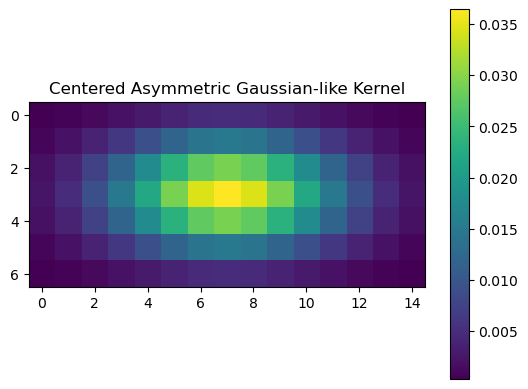

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve


def create_centered_asymmetric_gaussian_kernel(width, height, sigma_x, sigma_y):
    """
    Create a centered asymmetric 2D Gaussian-like kernel with the shape of a rectangle.

    Parameters:
    - width: Width of the rectangle.
    - height: Height of the rectangle.
    - sigma_x: Standard deviation along the x-axis.
    - sigma_y: Standard deviation along the y-axis.

    Returns:
    - 2D numpy array representing the centered asymmetric Gaussian-like kernel.
    """
    x = np.arange(-width // 2, width // 2 + 1, 1, float)
    y = np.arange(-height // 2, height // 2 + 1, 1, float)[:, np.newaxis]

    # Create 1D Gaussian kernels along x and y directions
    kernel_x = np.exp(-0.5 * (x / sigma_x) ** 2)
    kernel_y = np.exp(-0.5 * (y / sigma_y) ** 2)

    # Normalize the kernels
    kernel_x /= np.sum(kernel_x)
    kernel_y /= np.sum(kernel_y)

    # Create 2D asymmetric Gaussian-like kernel
    kernel = np.outer(kernel_y, kernel_x)

    return kernel

# Apply the centered asymmetric Gaussian-like kernel to an image
def apply_gaussian_kernel_to_image(image, kernel):
    return convolve(image, kernel, mode='reflect')


# Example usage:
rect_width = 14
rect_height = 6
sigma_x = 3
sigma_y = 1.5

# Create a centered asymmetric Gaussian-like kernel
centered_asymmetric_gaussian_kernel = create_centered_asymmetric_gaussian_kernel(rect_width, rect_height, sigma_x, sigma_y)

# Display the kernel using matplotlib
plt.imshow(centered_asymmetric_gaussian_kernel, cmap='viridis', interpolation='nearest')
plt.title('Centered Asymmetric Gaussian-like Kernel')
plt.colorbar()
plt.show()


In [6]:
import cv2
import numpy as np
from scipy.ndimage import maximum_filter
from scipy.ndimage import convolve


def find_local_maxima(image, neighborhood_size=10):
    # Find the local maxima using the maximum_filter function
    local_maxima = (image == maximum_filter(image, footprint=np.ones((neighborhood_size, neighborhood_size))))

    # Convert boolean array to coordinates of local maxima
    coordinates = np.column_stack(np.where(local_maxima))

    return coordinates

# Example usage:
image_path = "openpiv_example/frame_0136.png"
image_path = "Test videos/9th Setup Phantom Flow/2_2mL_min_2/frame_0138.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)[300:850, 650:1500]

# Apply the kernel to the image
filtered_image = apply_gaussian_kernel_to_image(image, centered_asymmetric_gaussian_kernel)

# Find local maxima in the image
maxima_coordinates = find_local_maxima(filtered_image)

# Draw red dots on the image at the locations of local maxima
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for coordinate in maxima_coordinates:
    cv2.circle(image, tuple(coordinate[::-1]), 1, (0, 0, 255), -1)  # -1 fills the circle

# Display the image with red dots
cv2.imshow("filterd image", filtered_image)
cv2.imshow("Image with Local Maxima", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


CREATE TEMPLATES

In [206]:
import cv2
import os

# Global variables
rectangles = []
cropped_images_folder = "cropped_images"

def draw_rectangle(event, x, y, flags, param):
    global rectangles
    if event == cv2.EVENT_LBUTTONDOWN:
        rectangles.append((x, y))
    elif event == cv2.EVENT_LBUTTONUP:
        rectangles[-1] = (rectangles[-1], (x, y))
        cv2.rectangle(image_copy, rectangles[-1][0], rectangles[-1][1], (0, 255, 0), 2)
        cv2.imshow("Image", image_copy)

# Create the cropped images folder
os.makedirs(cropped_images_folder, exist_ok=True)

# Load the image
image = cv2.imread("Test videos/11th Setup Piezo 1Mhz Silicium/Side_on_off_20Vpp_2/frame_0090.png")
image_copy = image.copy()

# Create a window and set the mouse callback function
cv2.namedWindow("Image")
cv2.setMouseCallback("Image", draw_rectangle)

while True:
    cv2.imshow("Image", image_copy)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("s"):  # Press 's' to save cropped images and exit
        for i, (pt1, pt2) in enumerate(rectangles):
            x1, y1 = pt1
            x2, y2 = pt2
            cropped_image = image[y1:y2, x1:x2]
            cv2.imwrite(os.path.join(cropped_images_folder, f"cropped_image_{i}.jpg"), cropped_image)
        break
    elif key == ord("q"):  # Press 'q' to exit without saving
        break

cv2.destroyAllWindows()

In [213]:
import cv2
import os

# Global variables
rectangles = []
cropped_images_folder = "cropped_images"
zoomed = False  # Flag to indicate if the image is zoomed
zoom_rect = None  # Zoom rectangle coordinates

def draw_rectangle(event, x, y, flags, param):
    global rectangles
    if event == cv2.EVENT_RBUTTONDOWN:
        rectangles.append((x, y))
    elif event == cv2.EVENT_RBUTTONUP:
        rectangles[-1] = (rectangles[-1], (x, y))
        cv2.rectangle(image_copy, rectangles[-1][0], rectangles[-1][1], (0, 255, 0), 2)
        cv2.imshow("Image", image_copy)

def zoom_image(event, x, y, flags, param):
    global zoomed, zoom_rect
    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:  # Zoom in
            zoom_rect = (x, y, 100, 100)  # Example: zoom by 100x100 pixels
        elif flags < 0:  # Zoom out
            zoom_rect = None

# Create the cropped images folder
os.makedirs(cropped_images_folder, exist_ok=True)

# Load the image
image = cv2.imread("Test videos/11th Setup Piezo 1Mhz Silicium/Side_on_off_20Vpp_2/frame_0090.png")
image_copy = image.copy()

# Create a window and set the mouse callback function
cv2.namedWindow("Image")
cv2.setMouseCallback("Image", draw_rectangle)

# Zoom functionality
cv2.setMouseCallback("Image", zoom_image)

while True:
    if not zoomed:
        cv2.imshow("Image", image_copy)
    else:
        if zoom_rect:
            zoomed_image = image_copy[zoom_rect[1]:zoom_rect[1]+zoom_rect[3], zoom_rect[0]:zoom_rect[0]+zoom_rect[2]]
            cv2.imshow("Image", zoomed_image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("s"):  # Press 's' to save cropped images and exit
        for i, (pt1, pt2) in enumerate(rectangles):
            x1, y1 = pt1
            x2, y2 = pt2
            cropped_image = image[y1:y2, x1:x2]
            cv2.imwrite(os.path.join(cropped_images_folder, f"cropped_image_{i}.jpg"), cropped_image)
        break
    elif key == ord("q"):  # Press 'q' to exit without saving
        break

cv2.destroyAllWindows()


TEMPLATE PYRAMID MATCHING

In [55]:
import cv2
import numpy as np

def template_pyramid_matching(image_path, template_path, num_scales=2):
    # Read the image and template
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

    # Create a pyramid of templates by resizing the original template
    template_pyramid = [template]
    for scale in range(1, num_scales):
        scaled_template = cv2.resize(template, (0, 0), fx=1.0/(2**scale), fy=1.0/(2**scale))
        template_pyramid.append(scaled_template)

    # Initialize the template matching method (e.g., TM_CCOEFF_NORMED)
    method = cv2.TM_CCOEFF_NORMED

    # Loop over each template scale
    for scale, scaled_template in enumerate(template_pyramid):
        # Match the template at the current scale
        result = cv2.matchTemplate(image, scaled_template, method)

        loc = np.where(result >= 0.95)

        # Draw rectangles around the detected regions
        h, w = scaled_template.shape
        for pt in zip(*loc[::-1]):
            top_left = pt
            bottom_right = (top_left[0] + w, top_left[1] + h)
            cv2.rectangle(image, top_left, bottom_right, 255, 1)

    # Display the result
    cv2.imshow('Template Pyramid Matching', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# Example usage:
image_path = "Test videos/11th Setup Piezo 1Mhz Silicium/Side_on_off_ 16Vpp/frame_0161.png"
template_path = "template/template.png"
template_pyramid_matching(image_path, template_path)


PHOTUTILS

C:\Users\lilap\AppData\Local\Temp\ipykernel_17976\2286734135.py:5: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder


 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 498.01611582846306 ... 1.1875687127076786   -0.1866468682400478
  2 24.318866929410063 ...  1.354168221306218  -0.32918154463769267
  3  787.4125492972217 ... 1.1502708870720102  -0.15200032024690507
  4 481.61848368870733 ... 1.0521445455971064 -0.055188520273651925
  5  49.76592248713631 ... 1.5009259758333324  -0.44089818450581275
  6  383.6844225537944 ... 1.0314711456196914  -0.03364270880632288
  7   87.8047023265996 ... 1.8773183954914947    -0.683844839356173
  8 120.82596785581568 ...  1.626371130919387   -0.5280491417654329
  9  604.5836034860224 ... 1.3035717215772755  -0.28783732682828456
 10  266.4315487228874 ... 2.2172653944626206   -0.8645441972115854
...                ... ...                ...                   ...
 27   820.990348079948 ... 2.4294709054680172   -0.9637792561613276
 28 24.728019005038913 ...   4.10725007493606   

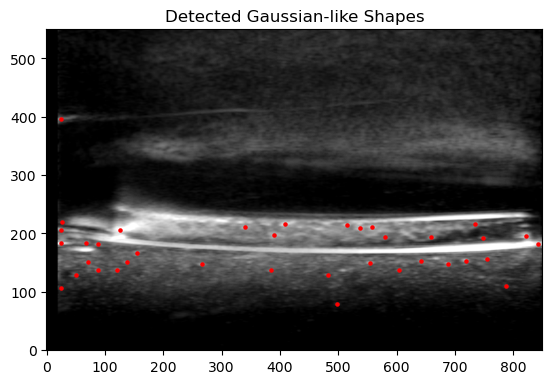

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.modeling.models import Gaussian2D
from photutils import DAOStarFinder
from astropy.stats import mad_std
import cv2

def detect_gaussian_like_shapes(image, fwhm, threshold):
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
    sources = daofind(image - np.median(image))

    # Print the found sources
    print(sources)

    # Plot the image with detected sources
    plt.imshow(image, cmap='gray', origin='lower')
    plt.scatter(sources['xcentroid'], sources['ycentroid'], color='red', marker='o', s=5)
    plt.title('Detected Gaussian-like Shapes')
    plt.show()

sigma = 5.0
fwhm = gaussian_sigma_to_fwhm * sigma
threshold = 100  # Adjust based on your data and noise level

image_path = "openpiv_example/frame_0136.png"
noisy_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Detect Gaussian-like shapes in the noisy data
detect_gaussian_like_shapes(noisy_data, fwhm, threshold)

 

None


C:\Users\lilap\AppData\Local\Temp\ipykernel_3788\352418908.py:5: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder


TypeError: 'NoneType' object is not subscriptable

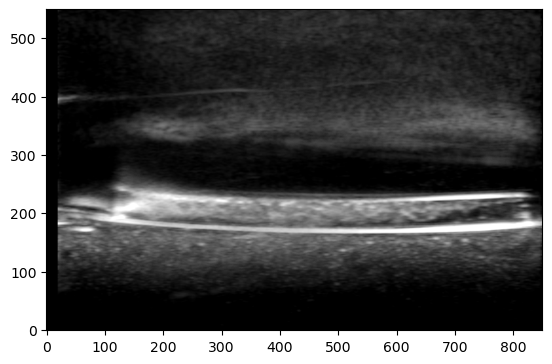

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.modeling.models import Gaussian2D
from photutils import DAOStarFinder
from astropy.stats import mad_std
import cv2

def create_centered_asymmetric_gaussian_kernel(width, height, sigma_x, sigma_y):
    """
    Create a centered asymmetric 2D Gaussian-like kernel with the shape of a rectangle.

    Parameters:
    - width: Width of the rectangle.
    - height: Height of the rectangle.
    - sigma_x: Standard deviation along the x-axis.
    - sigma_y: Standard deviation along the y-axis.

    Returns:
    - 2D numpy array representing the centered asymmetric Gaussian-like kernel.
    """
    x = np.arange(-width // 2, width // 2 + 1, 1, float)
    y = np.arange(-height // 2, height // 2 + 1, 1, float)[:, np.newaxis]

    # Create 1D Gaussian kernels along x and y directions
    kernel_x = np.exp(-0.5 * (x / sigma_x) ** 2)
    kernel_y = np.exp(-0.5 * (y / sigma_y) ** 2)

    # Normalize the kernels
    kernel_x /= np.sum(kernel_x)
    kernel_y /= np.sum(kernel_y)

    # Create 2D asymmetric Gaussian-like kernel
    kernel = np.outer(kernel_y, kernel_x)

    return kernel

def detect_gaussian_like_shapes(image, fwhm, threshold):
    # Use Gaussian2D model to create an anisotropic Gaussian kernel
    # gaussian_model = Gaussian2D(amplitude=1.0, x_mean=0, y_mean=0, x_stddev=fwhm, y_stddev=fwhm*2)  # Adjust stddev ratio as needed
    # kernel = gaussian_model(np.arange(-5*fwhm, 5*fwhm), np.arange(-5*fwhm, 5*fwhm))
    rect_width = 14
    rect_height = 6
    sigma_x = 3
    sigma_y = 1.5

    # Create a centered asymmetric Gaussian-like kernel
    kernel = create_centered_asymmetric_gaussian_kernel(rect_width, rect_height, sigma_x, sigma_y)

    # Normalize the kernel to sum to 1
    kernel /= np.sum(kernel)

    # Convolve the image with the anisotropic Gaussian kernel
    smoothed_image = cv2.filter2D(image.astype(float), -1, kernel, borderType=cv2.BORDER_CONSTANT)

    # Use DAOStarFinder on the smoothed image
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
    sources = daofind(smoothed_image - np.median(smoothed_image))

    # Print the found sources
    print(sources)

    # Plot the image with detected sources
    plt.imshow(image, cmap='gray', origin='lower')
    plt.scatter(sources['xcentroid'], sources['ycentroid'], color='red', marker='o', s=5)
    plt.title('Detected Gaussian-like Shapes')
    plt.show()

sigma = 1.5
fwhm = gaussian_sigma_to_fwhm * sigma
threshold = 50  # Adjust based on your data and noise level

image_path = "openpiv_example/frame_0136.png"
noisy_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Detect Gaussian-like shapes in the noisy data with anisotropic Gaussian
detect_gaussian_like_shapes(noisy_data, fwhm, threshold)


USED TO FIND CROPPED DATA FRAME

In [ ]:
# importing the module 
import cv2 

   
# function to display the coordinates of 
# of the points clicked on the image  
def click_event(event, x, y, flags, params): 
  
    # checking for left mouse clicks 
    if event == cv2.EVENT_LBUTTONDOWN: 
  
        # displaying the coordinates 
        # on the Shell 
        print(x, ' ', y) 
  
        # displaying the coordinates 
        # on the image window 
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(frame, str(x) + ',' +
                    str(y), (x,y), font, 
                    1, (255, 0, 0), 2) 
        cv2.imshow('First Frame', frame)
  
    # checking for right mouse clicks      
    if event==cv2.EVENT_RBUTTONDOWN: 
  
        # displaying the coordinates 
        # on the Shell 
        print(x, ' ', y) 
  
        # displaying the coordinates 
        # on the image window 
        font = cv2.FONT_HERSHEY_SIMPLEX 
        b = frame[y, x, 0] 
        g = frame[y, x, 1] 
        r = frame[y, x, 2] 
        cv2.putText(frame, str(b) + ',' +
                    str(g) + ',' + str(r), 
                    (x,y), font, 1, 
                    (255, 255, 0), 2) 
        cv2.imshow('First Frame', frame)
  
# driver function 
if __name__=="__main__": 
    
    filepath = 'C:/Users/lilap/OneDrive/Documents/Master ETHZ/ARSL Semester Project/Test videos/2nd Setup cavity_pump/0.2ml_sec test.avi'
  
    # Create a VideoCapture object
    cap = cv2.VideoCapture(filepath)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        exit()

    # Read the first frame
    ret, frame = cap.read()
    frame = frame[110:914,266:1302]

    # Check if the frame was read successfully
    if not ret:
        print("Error: Couldn't read the first frame.")
        exit()

    # Display the first frame
    cv2.namedWindow('First Frame', cv2.WINDOW_KEEPRATIO)
    cv2.imshow('First Frame', frame)
 
    # setting mouse handler for the image 
    # and calling the click_event() function 
    cv2.setMouseCallback('First Frame', click_event) 
  
    # wait for a key to be pressed to exit 
    cv2.waitKey(0) 
  
    # close the window 
    cv2.destroyAllWindows() 

REMOVE BACKGROUND

In [ ]:
import cv2

def save_frames(video_path, output_folder):
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        return

    # Create output folder if it doesn't exist
    import os
    os.makedirs(output_folder, exist_ok=True)

    # Loop through the first four frames
    for frame_number in range(4):
        # Read the frame
        ret, frame = cap.read()

        # Check if the frame was read successfully
        if not ret:
            print(f"Error: Couldn't read frame {frame_number}. Exiting.")
            return

        # Save the frame as an image file
        output_path = os.path.join(output_folder, f"frame_{frame_number + 1}.png")
        cv2.imwrite(output_path, frame[110:914,266:1302])
        print(f"Saved frame {frame_number + 1} to {output_path}")

    # Release the VideoCapture object
    cap.release()

# Replace 'your_video_file.mp4' with the actual path to your video file
video_path = r'Test videos\2nd Setup cavity_pump\0.6ml_sec.avi'

# Replace 'output_frames' with the desired output folder
output_folder = '0.6ml_sec'

save_frames(video_path, output_folder)


Saved frame 1 to 0.6ml_sec\frame_1.png
Saved frame 2 to 0.6ml_sec\frame_2.png
Saved frame 3 to 0.6ml_sec\frame_3.png
Saved frame 4 to 0.6ml_sec\frame_4.png


In [ ]:
from skimage import exposure, filters, util
from openpiv import preprocess as piv_pre
import openpiv.tools as piv_tls
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os

i1 = 'Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png'
i2 = 'Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png'
i3 = 'Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png'
i4 = 'Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png'
img_list = [i1, i2, i3, i4]

# image_folder = 'Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2'
# img_list = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# img_list.sort()

# img_list = [image_folder + '\\' + file for file in os.listdir(image_folder) if file.endswith(".png")]
# print(img_list)

# temporal filtering
background_min = piv_pre.gen_min_background(img_list, resize = 255)
# works better than min of images for low amount of images, produces less invalid vectors 
background_low = piv_pre.gen_lowpass_background(img_list, resize = 255) 
# normalizing can be disabled by setting »resize« to None

fig, ax = plt.subplots(2,2, figsize = (13, 13))
img = piv_pre.normalize_array(piv_tls.imread(i1))*255
new_img = img - background_low
new_img[new_img < 0] = 0
ax[0,0].imshow(img, cmap = plt.cm.gray, vmax = 255)
ax[0,1].imshow(background_min, cmap = plt.cm.gray, vmax = 255)
ax[1,1].imshow(background_low, cmap = plt.cm.gray, vmax = 255)
ax[1,0].imshow(new_img, cmap = plt.cm.gray, vmax = 255)
ax[0,0].set_title('Original')
ax[0,1].set_title('Min background')
ax[1,1].set_title('Lowpass background')
ax[1,0].set_title('Temporal high pass')

Text(0.5, 1.0, 'Temporal high pass')

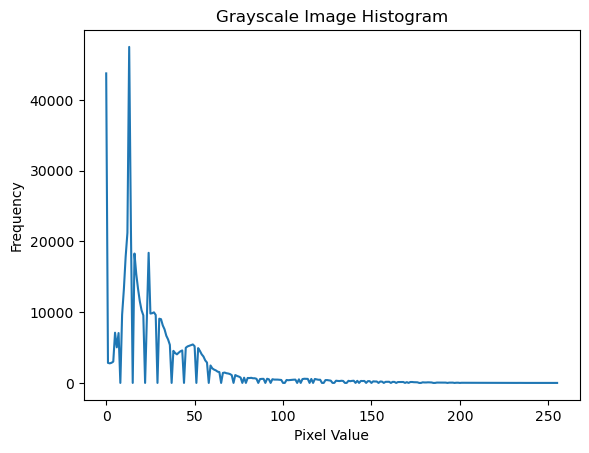

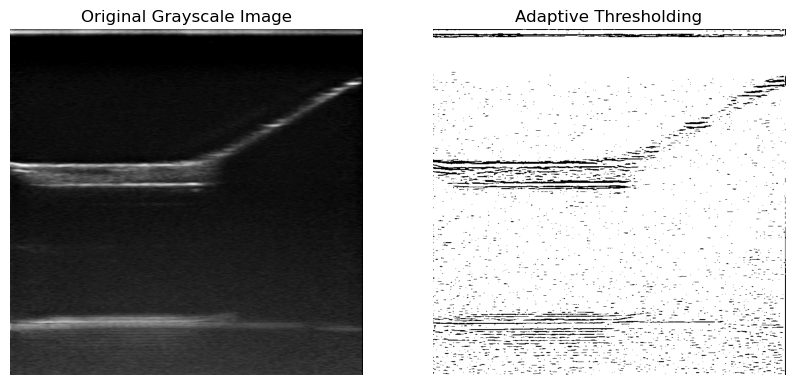

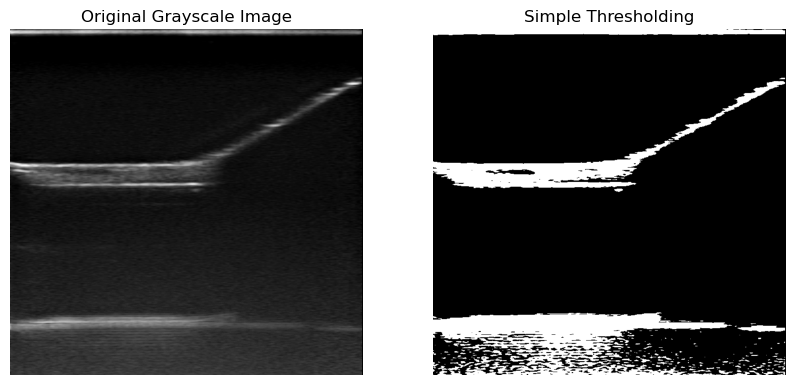

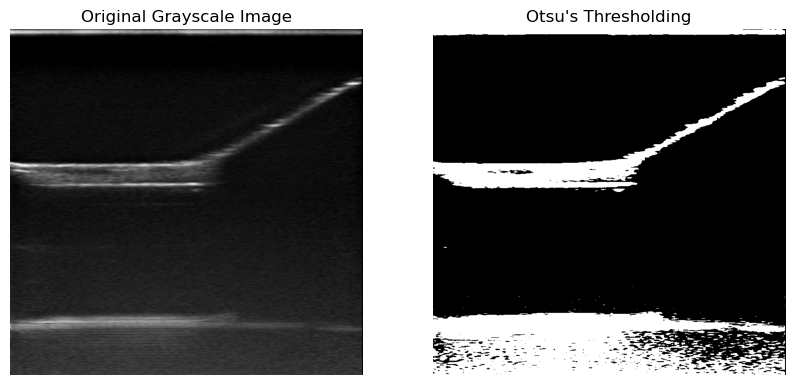

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image in color
image = cv2.imread("Test videos\\3rd Setup Y_pump\\0.4ml_sec\\frame_0000.png", cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded successfully
if image is None:
    print("Error: Unable to load the image.")
    exit()

# Calculate the histogram
hist = cv2.calcHist([image], [0], None, [256], [0, 256])
# Plot the histogram
plt.plot(hist)
plt.title('Grayscale Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

# Apply adaptive thresholding
adaptive_threshold = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5
)

# Display the original and thresholded images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adaptive_threshold, cmap='gray')
plt.title('Adaptive Thresholding')
plt.axis('off')

plt.show()

# Apply simple thresholding
_, simple_threshold = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)

# Display the original and thresholded images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(simple_threshold, cmap='gray')
plt.title('Simple Thresholding')
plt.axis('off')

plt.show()

# Apply Otsu's thresholding
_, otsu_threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the original and thresholded images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(otsu_threshold, cmap='gray')
plt.title('Otsu\'s Thresholding')
plt.axis('off')

plt.show()

In [ ]:
import torch
from segment_anything import sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

NameError: name 'CHECKPOINT_PATH' is not defined

LEE FILTER

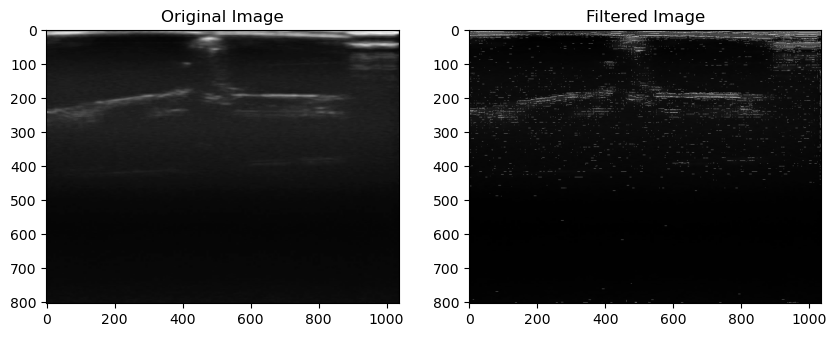

In [ ]:
import numpy as np
from scipy.ndimage import uniform_filter

def lee_filter(img, window_size):
    # Calculate local mean using a uniform filter
    local_mean = uniform_filter(img, size=window_size)

    # Calculate local variance
    local_variance = uniform_filter(img**2, size=window_size) - local_mean**2

    # Estimate noise standard deviation
    sigma_noise = np.mean(np.sqrt(np.abs(local_variance)))

    # Compute signal-to-noise ratio (SNR)
    snr = np.maximum(0.001, img - local_mean) / (sigma_noise + 0.001)

    # Apply the Lee filter
    filtered_img = local_mean + (snr**2 / (1 + snr**2)) * (img - local_mean)

    return filtered_img

# Example usage
import matplotlib.pyplot as plt
import cv2
# Load example ultrasound image (replace with your own image loading)
image = cv2.imread('0.6ml_sec/frame_2.png', cv2.IMREAD_GRAYSCALE)

# Convert to numpy array if needed
image = np.array(image)

# Set the window size (you may need to experiment with this value)
window_size = 3

# Apply Lee filter
filtered_image = lee_filter(image, window_size)

# Display the original and filtered images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')

plt.show()


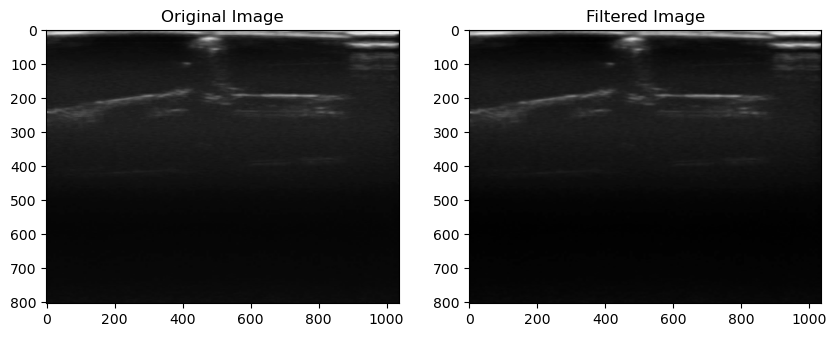

In [ ]:
import numpy as np

""" from utils import assert_window_size
from utils import assert_indices_in_range """

COEF_VAR_DEFAULT = 0.01
CU_DEFAULT = 0.25


def weighting(window, cu=CU_DEFAULT):
    """
    Computes the weighthing function for Lee filter using cu as the noise
    coefficient.
    """
    # cu is the noise variation coefficient
    two_cu = cu * cu

    # ci is the variation coefficient in the window
    window_mean = window.mean()
    window_std = window.std()
    ci = window_std / window_mean

    two_ci = ci * ci

    if not two_ci:  # dirty patch to avoid zero division
        two_ci = COEF_VAR_DEFAULT

    if cu > ci:
        w_t = 0.0
    else:
        w_t = 1.0 - (two_cu / two_ci)

    return w_t


def lee_filter(img, win_size=3, cu=CU_DEFAULT):
    """
    Apply lee to a numpy matrix containing the image, with a window of
    win_size x win_size.
    """
    # assert_window_size(win_size)

    # we process the entire img as float64 to avoid type overflow error
    img = np.float64(img)
    img_filtered = np.zeros_like(img)
    N, M = img.shape
    win_offset = win_size / 2

    for i in range(0, N):
        xleft = int(i - win_offset)
        xright = int(i + win_offset)

        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N

        for j in range(0, M):
            yup = int(j - win_offset)
            ydown = int(j + win_offset)

            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M

            # assert_indices_in_range(N, M, xleft, xright, yup, ydown)

            pix_value = img[i, j]
            # print(xleft,xright,yup,ydown)
            window = img[xleft:xright, yup:ydown]
            w_t = weighting(window, cu)
            window_mean = window.mean()
            new_pix_value = (pix_value * w_t) + (window_mean * (1.0 - w_t))

            assert new_pix_value >= 0.0, \
                    "ERROR: lee_filter(), pixel filtered can't be negative"

            img_filtered[i, j] = round(new_pix_value)

    return img_filtered


# Example usage
import matplotlib.pyplot as plt
import cv2
# Load example ultrasound image (replace with your own image loading)
image = cv2.imread('0.6ml_sec/frame_2.png', cv2.IMREAD_GRAYSCALE)

# Convert to numpy array if needed
image = np.array(image)

# Set the window size (you may need to experiment with this value)
window_size = 3

# Apply Lee filter
filtered_image = lee_filter(image, window_size)

# Display the original and filtered images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')

plt.show()

In [ ]:
%pip install findpeaks

  Obtaining dependency information for findpeaks from https://files.pythonhosted.org/packages/69/68/1a47cf1663d5d3c25a1007f873e5ceb9ccc46e3b09f22f0ecf385146f310/findpeaks-2.6.1-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/53.8 kB ? eta -:--:--
   ---------------------- ----------------- 30.7/53.8 kB ? eta -:--:--
   ---------------------- ----------------- 30.7/53.8 kB ? eta -:--:--
   ------------------------------ --------- 41.0/53.8 kB 245.8 kB/s eta 0:00:01
   ---------------------------------------- 53.8/53.8 kB 311.2 kB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=972f1fa09e18a57f87aa8a8689fd6fc7050931e33c877a7816d8e0421ffc1eab
  Stored in directory: c:\users\lilap\appdata\local\pip\cache\wheels\40\b3\0f\a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
Note: you may need to resta

The input parameter "window" will be deprecated in future releases. Please use "params={"window": 5}" instead.
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Conversion to gray image.
[findpeaks] >Detect peaks using topology method with limit at 15.
[findpeaks] >Detect peaks using topology method with limit at 15.
[findpeaks] >Fin.
[findpeaks] >Plotting 3d-mesh..


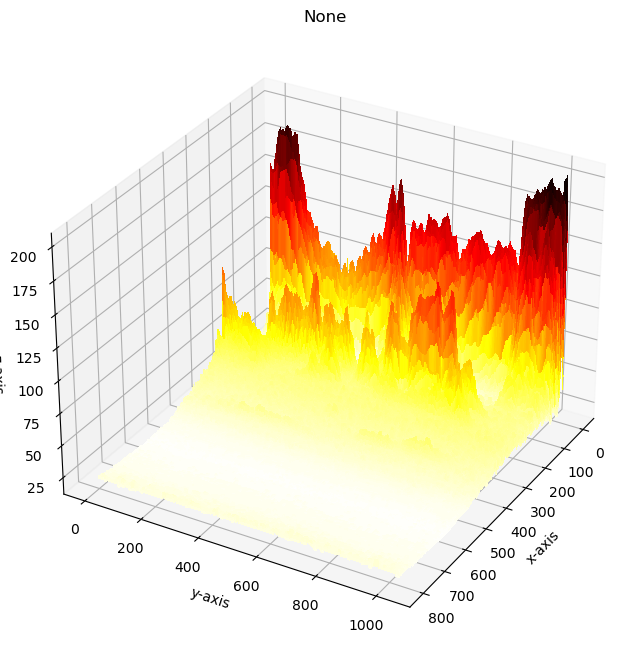

The input parameter "window" will be deprecated in future releases. Please use "params={"window": 5}" instead.
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Conversion to gray image.
[findpeaks] >Denoising with [lee], window: [3].
[findpeaks] >Detect peaks using topology method with limit at 15.0.
[findpeaks] >Detect peaks using topology method with limit at 15.0.
[findpeaks] >Fin.
[findpeaks] >Plotting 3d-mesh..


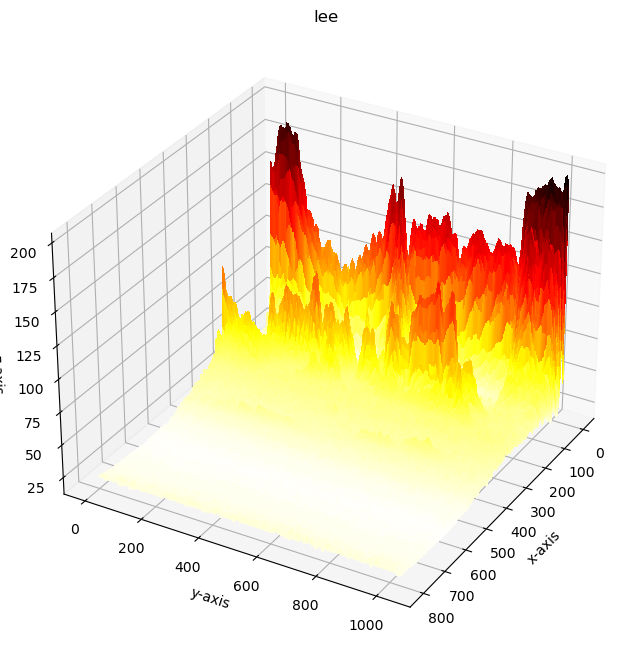

The input parameter "window" will be deprecated in future releases. Please use "params={"window": 5}" instead.
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Conversion to gray image.
[findpeaks] >Denoising with [lee_enhanced], window: [3].


KeyboardInterrupt: 

In [ ]:
from findpeaks import findpeaks

# Read image
img = cv2.imread('0.6ml_sec/frame_1.png')

filters = [None, 'lee','lee_enhanced','kuan', 'fastnl','bilateral','frost','median','mean']

for getfilter in filters:
    fp = findpeaks(method='topology', scale=False, denoise=getfilter, togray=True, imsize=False, window=15)
    fp.fit(img)
    fp.plot_mesh(wireframe=False, title=str(getfilter), view=(30,30))

In [ ]:
from findpeaks import findpeaks
# Some pre-processing
# Make grey image
img = findpeaks.stats.togray(img)
# Scale between [0-255]
img = findpeaks.stats.scale(img)

# Denoising
# fastnl
img_fastnl = findpeaks.stats.denoise(img, method='fastnl', window=winsize)
# bilateral
img_bilateral = findpeaks.stats.denoise(img, method='bilateral', window=winsize)
# frost filter
image_frost = findpeaks.frost_filter(img, damping_factor=k_value1, win_size=winsize)
# kuan filter
image_kuan = findpeaks.kuan_filter(img, win_size=winsize, cu=cu_value)
# lee filter
image_lee = findpeaks.lee_filter(img, win_size=winsize, cu=cu_value)
# lee enhanced filter
image_lee_enhanced = findpeaks.lee_enhanced_filter(img, win_size=winsize, k=k_value2, cu=cu_lee_enhanced, cmax=cmax_value)
# mean filter
image_mean = findpeaks.mean_filter(img, win_size=winsize)
# median filter
image_median = findpeaks.median_filter(img, win_size=winsize)


plt.figure(); plt.imshow(img_fastnl, cmap='gray'); plt.title('Fastnl')
plt.figure(); plt.imshow(img_bilateral, cmap='gray'); plt.title('Bilateral')
plt.figure(); plt.imshow(image_frost, cmap='gray'); plt.title('Frost')
plt.figure(); plt.imshow(image_kuan, cmap='gray'); plt.title('Kuan')
plt.figure(); plt.imshow(image_lee, cmap='gray'); plt.title('Lee')
plt.figure(); plt.imshow(image_lee_enhanced, cmap='gray'); plt.title('Lee Enhanced')
plt.figure(); plt.imshow(image_mean, cmap='gray'); plt.title('Mean')
plt.figure(); plt.imshow(image_median, cmap='gray'); plt.title('Median')

AttributeError: type object 'findpeaks' has no attribute 'stats'

[findpeaks] >Import [c:\Users\lilap\anaconda3\Lib\site-packages\findpeaks\data\2dpeaks_image.png]
[findpeaks] >Conversion to gray image.
[findpeaks] >Scaling image between [0-255] and to uint8


Text(0.5, 1.0, 'Lee filter')

<Figure size 640x480 with 0 Axes>

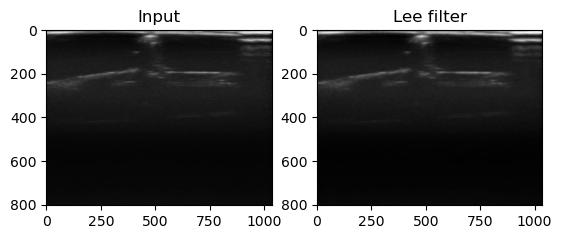

In [ ]:
import findpeaks
import matplotlib.pyplot as plt
import cv2

img = findpeaks.import_example('2dpeaks_image')
img = cv2.imread('0.6ml_sec/frame_4.png')
# Resize
# img = findpeaks.stats.resize(img, size=(300,300))
# Make grey image
img = findpeaks.stats.togray(img)
# Scale between [0-255]
img = findpeaks.stats.scale(img)
# Filter
img_filtered = findpeaks.stats.lee_filter(img.copy(), win_size=7, cu=0.25)

plt.figure()
fig, axs = plt.subplots(1,2)
axs[0].imshow(img, cmap='gray'); axs[0].set_title('Input')
axs[1].imshow(img_filtered, cmap='gray'); axs[1].set_title('Lee filter')

REMOVE TRANSDUCER SIGNAL WITH FOURIER

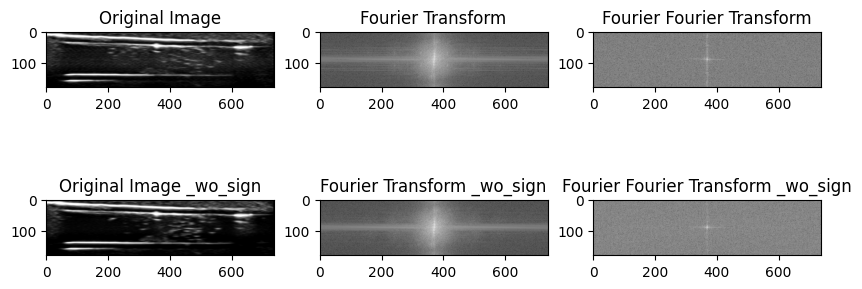

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


img = cv2.imread('Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0074.png', cv2.IMREAD_GRAYSCALE)[200:380]
img_wo_sign = cv2.imread('Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png', cv2.IMREAD_GRAYSCALE)[200:380]

fourier_transform = np.fft.fft2(img)
center_shift = np.fft.fftshift(fourier_transform)
fourier_noisy = 20 * np.log(np.abs(center_shift))
fourier_noisy = fourier_noisy.astype(int)

fourier_fourier = np.fft.fft2(fourier_noisy)
fourier_center_shift = np.fft.fftshift(fourier_fourier)
fourier_fourier_noisy = 20 * np.log(np.abs(fourier_center_shift))
fourier_fourier_noisy = fourier_fourier_noisy.astype(int)

fourier_transform_wo_sign = np.fft.fft2(img_wo_sign)
center_shift_wo_sign = np.fft.fftshift(fourier_transform_wo_sign)
fourier_noisy_wo_sign = 20 * np.log(np.abs(center_shift_wo_sign))
fourier_noisy_wo_sign = fourier_noisy_wo_sign.astype(int)

fourier_fourier_wo_sign = np.fft.fft2(fourier_noisy_wo_sign)
fourier_center_shift_wo_sign = np.fft.fftshift(fourier_fourier_wo_sign)
fourier_fourier_noisy_wo_sign = 20 * np.log(np.abs(fourier_center_shift_wo_sign))
fourier_fourier_noisy_wo_sign = fourier_fourier_noisy_wo_sign.astype(int)

# cv2.imshow('image',img)
# cv2.imshow('fourier noisy', fourier_noisy)
# # waits for user to press any key 
# # (this is necessary to avoid Python kernel form crashing) 
# cv2.waitKey(0) 

# # closing all open windows 
# cv2.destroyAllWindows()

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(2, 3, 1)
ax1.title.set_text("Original Image")
ax1.imshow(img, cmap='gray')
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(fourier_noisy, cmap='gray')
ax2.title.set_text("Fourier Transform")
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(fourier_fourier_noisy, cmap='gray')
ax3.title.set_text("Fourier Fourier Transform")
ax4 = fig.add_subplot(2, 3, 4)
ax4.title.set_text("Original Image _wo_sign")
ax4.imshow(img_wo_sign, cmap='gray')
ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(fourier_noisy_wo_sign, cmap='gray')
ax5.title.set_text("Fourier Transform _wo_sign")
ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(fourier_fourier_noisy_wo_sign, cmap='gray')
ax6.title.set_text("Fourier Fourier Transform _wo_sign")

plt.show()

TEMPLATE MATCHING

In [17]:
import numpy as np

def find_max_values_with_distance(data, num_values, min_distance):
    array_data = np.array(data)
    max_indices = []

    for _ in range(num_values):
        # Find the index of the maximum value
        flat_indices = np.argmax(array_data)
        index_2d = np.unravel_index(flat_indices, array_data.shape)

        # Add the index to the result
        max_indices.append(index_2d)

        # Set the neighborhood around the selected index to zero
        neighborhood = slice(index_2d[0] - min_distance, index_2d[0] + min_distance + 1), \
                       slice(index_2d[1] - min_distance, index_2d[1] + min_distance + 1)
        array_data[neighborhood] = 0
    
    # Convert the list of tuples to a tuple containing two arrays
    indices_2d = tuple(np.array(x) for x in zip(*max_indices))

    return indices_2d

def plot_microbubbles(images):
    num_images = len(images)
    num_rows = (num_images + 3) // 4  # Calculate the number of rows needed

    fig, axs = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))

    for i, ax in enumerate(axs.flatten()):
        if i < num_images:
            ax.imshow(images[i], cmap='gray')
            ax.title.set_text("microbubble "+str(i))
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots

    plt.show()

In [ ]:
from PIL import Image, ImageDraw

# Create a black image with a size of 25x5 pixels
width, height = 25, 5
image = Image.new("RGB", (width, height), "black")
draw = ImageDraw.Draw(image)

# Define the bounding box of the ellipsoid within the image
ellipsoid_bbox = [2, 1, 22, 4]

# Draw a white ellipsoid on the black image
draw.ellipse(ellipsoid_bbox, fill="white")

# Save or display the image
image.save("ellipsoid_image.png")
image.show()

print(draw)

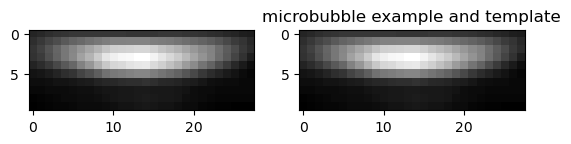

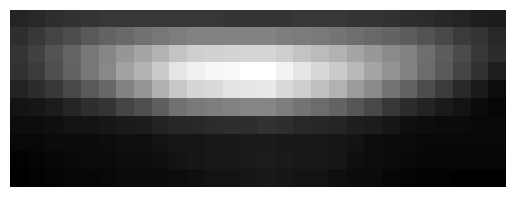

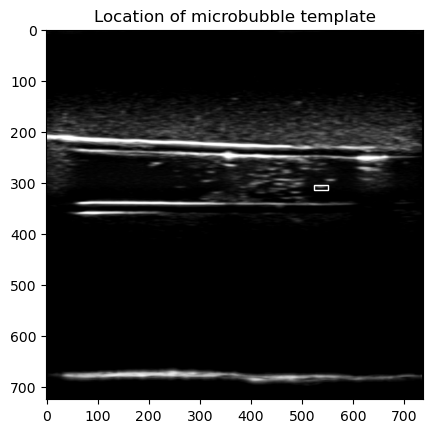

(array([400, 361, 666, 685, 656, 672, 600, 385, 407, 427], dtype=int64), array([ 824,  660, 1352, 1397,  807,  880, 1051, 1031, 1017,  988],
      dtype=int64))


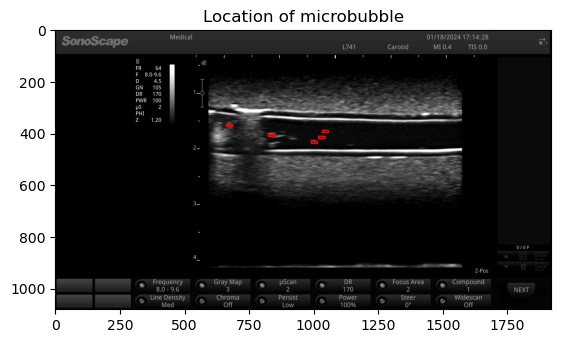

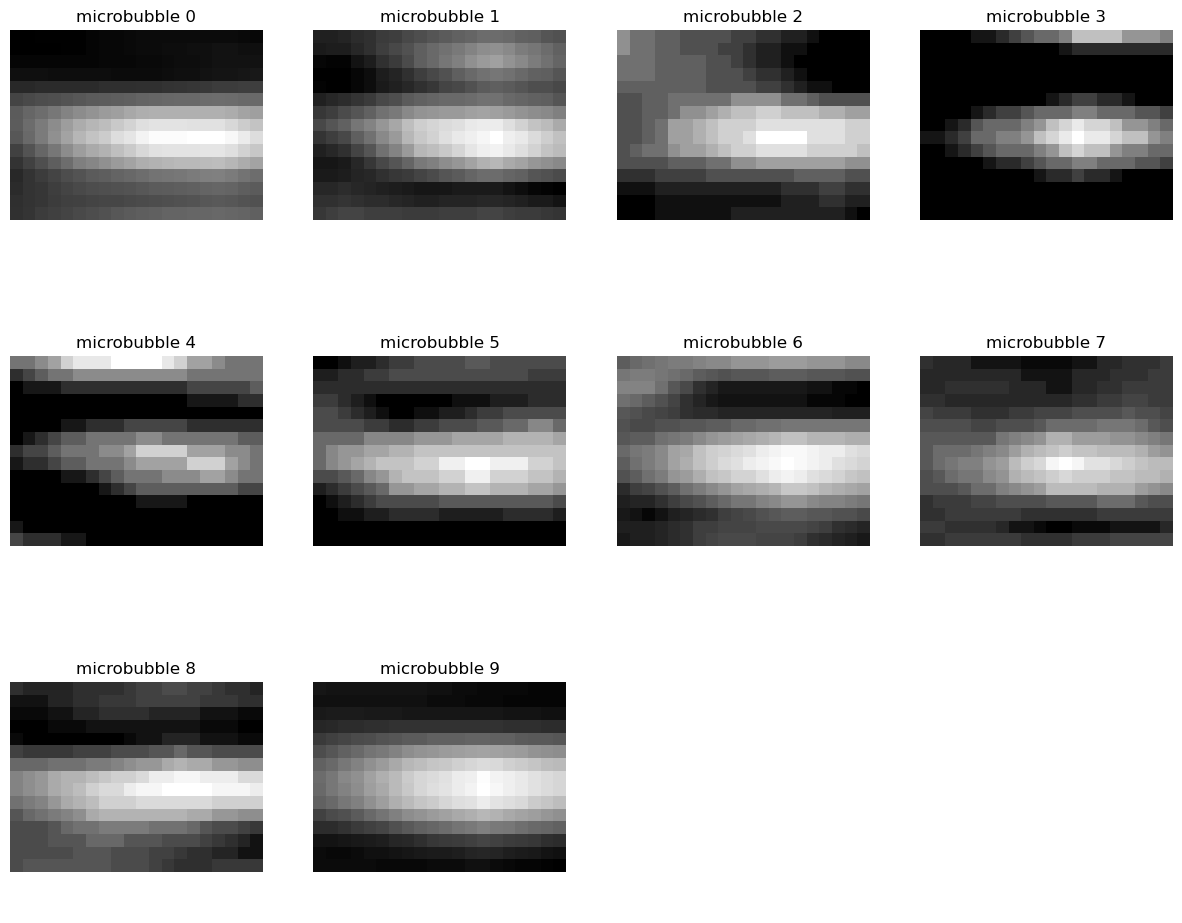

"img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)\nfor i in range(len(x_)):\n    cv2.rectangle(img, (x_[i], y_[i]), (x_[i]+25, y_[i]+10), (255,0,0), thickness=1, lineType=cv2.LINE_AA)\ncv2.imshow('img', img[360:420, 960:1030])\ncv2.imwrite('Report/Images/without NMS.png', img[360:420, 960:1030])\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n\nplt.imshow(img[360:420, 960:1030])\nplt.axis('off')  # Hide axis\nplt.show()"

In [397]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import match_template
import numpy as np

img_template = cv2.imread('Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread("Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V\\frame_0459.png", cv2.IMREAD_GRAYSCALE)

bubble = cv2.imread('template/template.png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread("Test videos/9th Setup Phantom Flow/2_2mL_min_2/frame_0000.png", cv2.IMREAD_GRAYSCALE)


# bubble = img_template[305:315, 524:552]
# bubble = cv2.equalizeHist(bubble)
# template = np.where(bubble < 160, 0, 256)
template = bubble

plt.subplot(121), plt.imshow(bubble, cmap='gray')
plt.subplot(122), plt.imshow(template, cmap='gray')
plt.title("microbubble example and template")
plt.show()

plt.imshow(template, cmap='gray')
plt.axis('off')
plt.show()

fig, ax = plt.subplots()
ax.imshow(img_template, cmap='gray')
rect = patches.Rectangle((524, 303), 28, 11, edgecolor='w', facecolor='none')
ax.add_patch(rect)
plt.title("Location of microbubble template")
plt.show()

result = match_template(img, template)

# # Convert the 2D list to a numpy array
# array_result = np.array(result)

# # Find the indices of the 10 maximum values
# flat_indices = np.argpartition(array_result.flatten(), -10)[-10:]

# Convert flat indices to 2D indices
# indices_2d = np.unravel_index(flat_indices, array_result.shape)
num_values = 10
min_distance = 5
indices_2d = find_max_values_with_distance(result, num_values, min_distance)
print(indices_2d)
x_, y_ = indices_2d[::-1]

ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

# plt.imshow(result)
# plt.title("heat map of template matching")
# plt.show()

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
for i in range(len(x_)):
    if y_[i] < 450:
        rect = patches.Rectangle((x_[i], y_[i]), 25, 10, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
plt.title("Location of microbubble")
plt.show()

images_microbubbles = [img[y_[i]-5:y_[i]+10, x_[i]:x_[i]+20] for i in range(num_values)]
plot_microbubbles(images_microbubbles)

#TEST with and without NMS
"""img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for i in range(len(x_)):
    cv2.rectangle(img, (x_[i], y_[i]), (x_[i]+25, y_[i]+10), (255,0,0), thickness=1, lineType=cv2.LINE_AA)
cv2.imshow('img', img[360:420, 960:1030])
cv2.imwrite('Report/Images/without NMS.png', img[360:420, 960:1030])
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(img[360:420, 960:1030])
plt.axis('off')  # Hide axis
plt.show()"""

# for i in range(num_values):
#     plt.imshow(img[y_[i]-5:y_[i]+10, x_[i]:x_[i]+20], cmap='gray')
#     plt.title("microbubble")
#     plt.show()

w,h 21 9


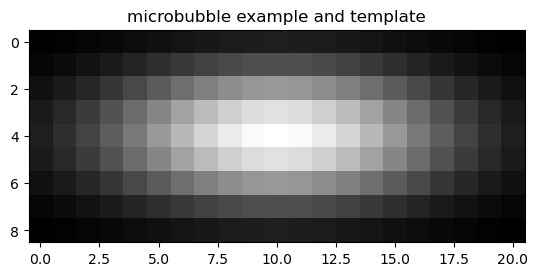

max (array([120, 120, 120, 123, 123, 123, 127, 127, 127, 132, 132, 132, 132,
       133, 133, 133, 138, 138, 138, 139, 140, 140, 140, 140, 141, 141,
       141, 142, 142, 150, 150, 154, 154, 154, 159, 159, 183, 183, 186,
       186, 189, 189, 189, 189, 193, 193, 193, 240, 240, 249, 249, 249,
       249, 257, 257, 257, 257, 259, 259, 259, 259, 260, 260, 260, 260,
       260, 262, 263, 263, 263, 266, 266, 266, 266, 266, 272, 272, 272,
       272, 272, 273, 273, 273, 275, 275, 275, 292, 292, 292, 292, 323,
       323, 323, 323, 370, 370, 370, 371, 371, 371, 372, 678], dtype=int64), array([682, 683, 684, 163, 164, 165, 603, 604, 605, 356, 357, 358, 359,
       356, 357, 358, 665, 666, 667, 482, 480, 481, 482, 483, 704, 705,
       706, 705, 706,  40,  41,  78,  79,  80, 416, 417, 429, 430, 256,
       257, 535, 536, 537, 538,  60,  61,  62,  20,  21, 306, 307, 308,
       309, 536, 537, 538, 539, 189, 190, 191, 192, 253, 254, 255, 256,
       257,  13,  12,  13,  14, 228, 229, 230, 231, 23

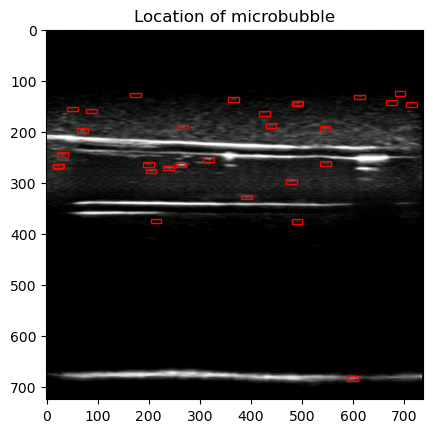

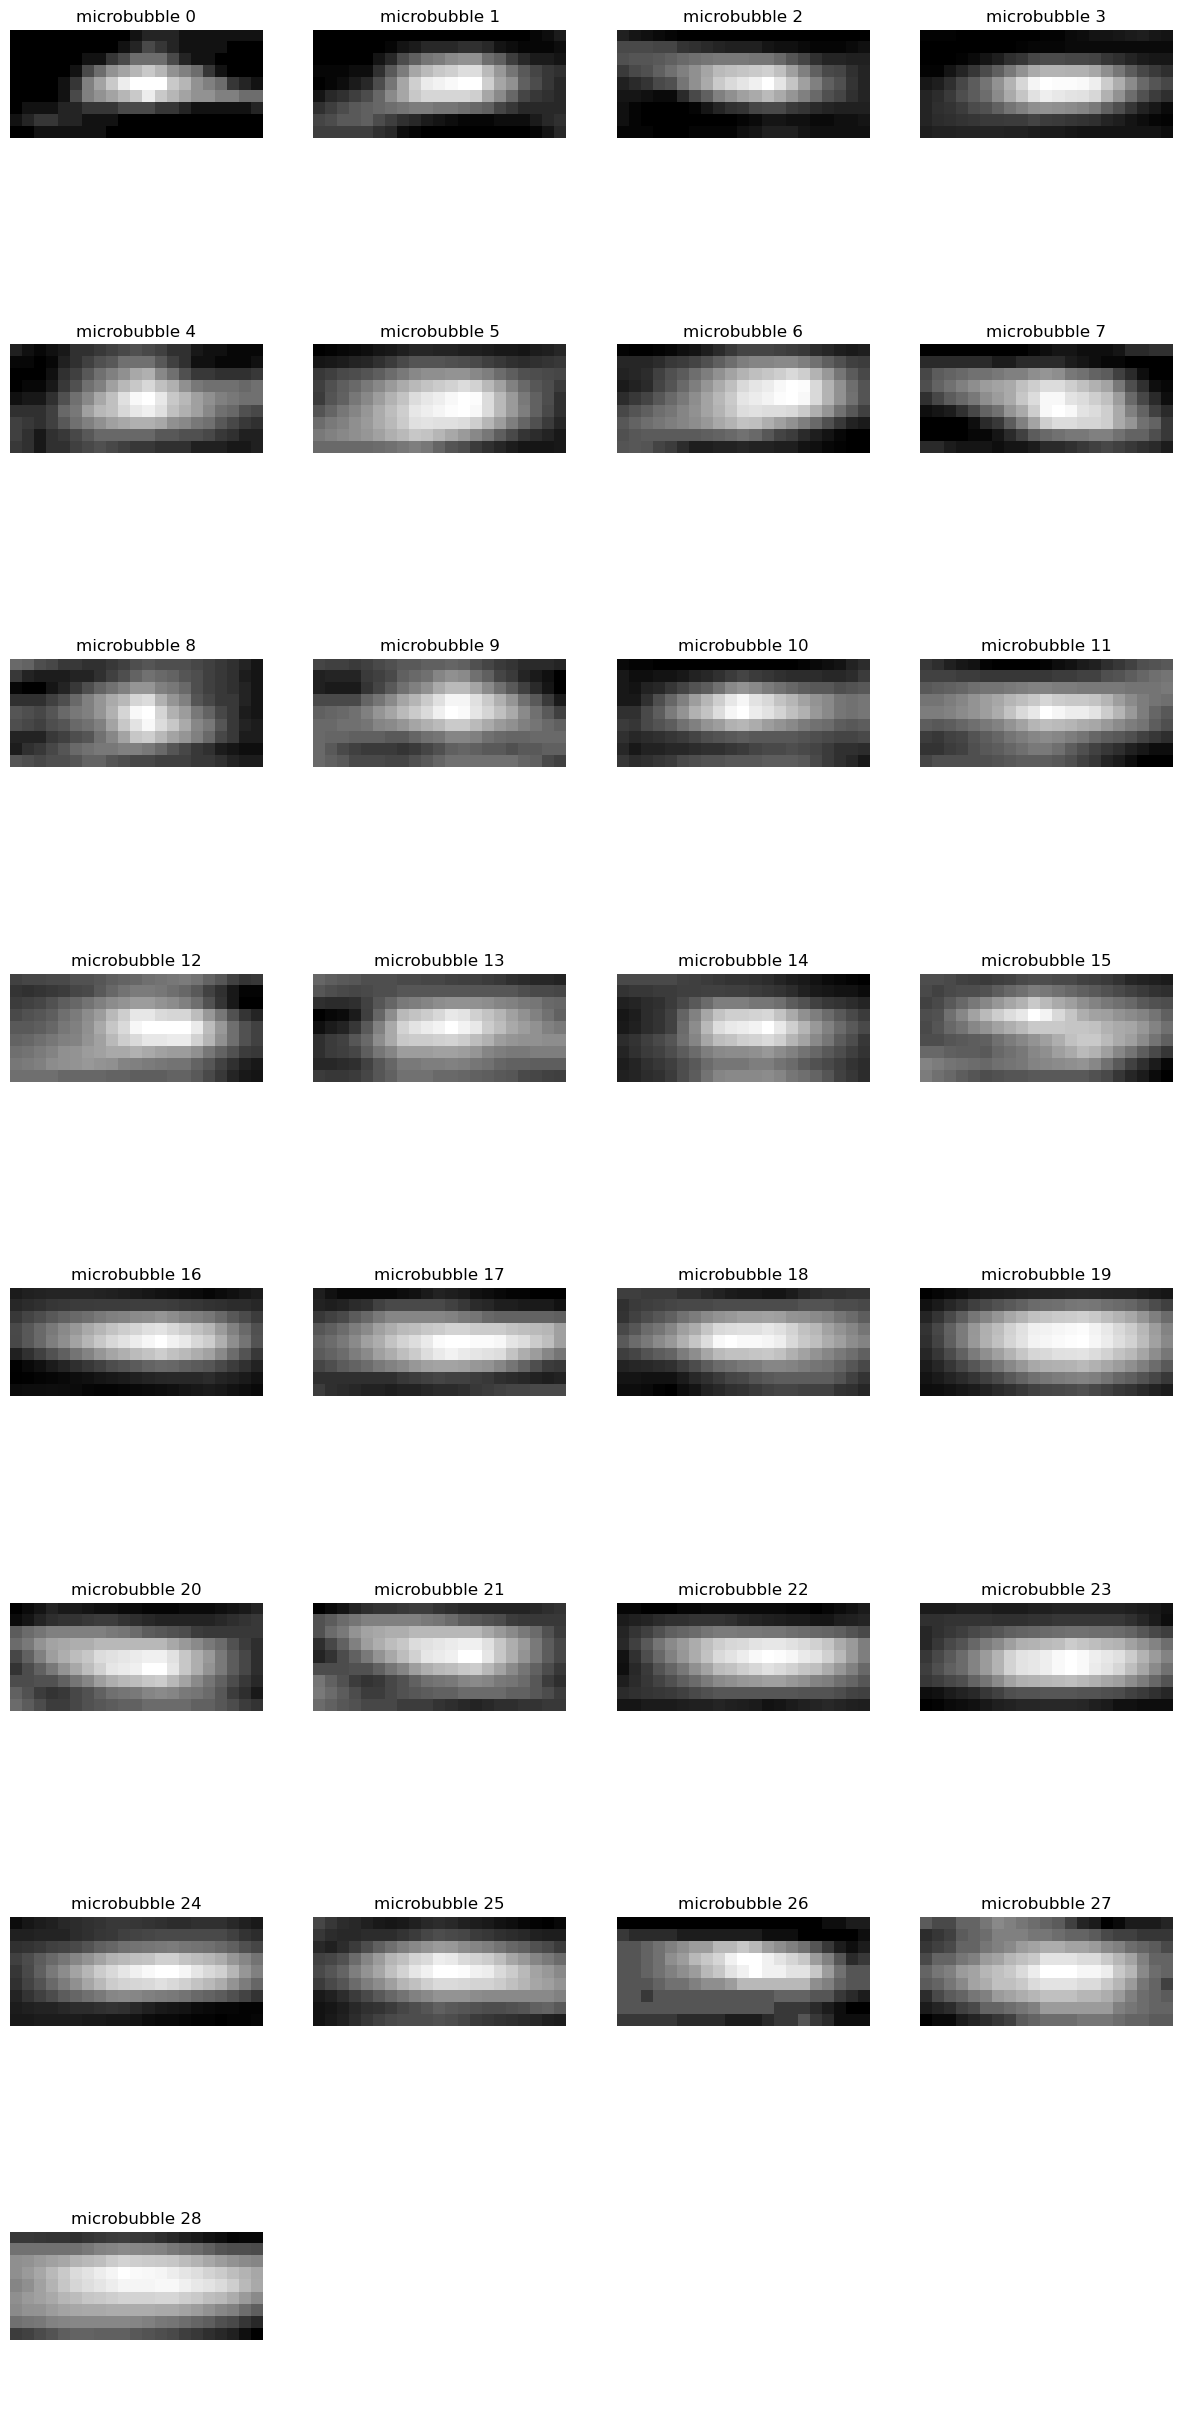

In [22]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time

def create_centered_asymmetric_gaussian_kernel(width, height, sigma_x, sigma_y):
    """
    Create a centered asymmetric 2D Gaussian-like kernel with the shape of a rectangle.

    Parameters:
    - width: Width of the rectangle.
    - height: Height of the rectangle.
    - sigma_x: Standard deviation along the x-axis.
    - sigma_y: Standard deviation along the y-axis.

    Returns:
    - 2D numpy array representing the centered asymmetric Gaussian-like kernel.
    """
    x = np.arange(-width // 2, width // 2 + 1, 1, float)
    y = np.arange(-height // 2, height // 2 + 1, 1, float)[:, np.newaxis]

    # Create 1D Gaussian kernels along x and y directions
    kernel_x = np.exp(-0.5 * (x / sigma_x) ** 2)
    kernel_y = np.exp(-0.5 * (y / sigma_y) ** 2)

    # Normalize the kernels
    kernel_x /= np.sum(kernel_x)
    kernel_y /= np.sum(kernel_y)

    # Create 2D asymmetric Gaussian-like kernel
    kernel = np.outer(kernel_y, kernel_x)

    return kernel

def filter_max_coordinates(max_coordinates):
    """
    Filter out coordinates of max values that are too close to each other.

    Parameters:
    - max_coordinates (tuple): 2D tuples of arrays representing coordinates. max_coordinates[0] is the array of x and max_coordinates[1] of y
    - min_distance (float): Minimum distance between max coordinates.

    Returns:
    - filtered_coordinates (list of tuples): Filtered coordinates.
    """

    def is_inside_rectangle(coord, rectangle):
        """
        Check if a coordinate is located inside a rectangle.

        Parameters:
        - coord (tuple): 2D tuple representing the coordinate (x, y).
        - rectangle (tuple): 4D tuple representing the rectangle (x_min, y_min, x_max, y_max).

        Returns:
        - is_inside (bool): True if the coordinate is inside the rectangle, False otherwise.
        """

        x, y = coord
        x_min, y_min, x_max, y_max = rectangle

        is_inside = x_min <= x <= x_max and y_min <= y <= y_max
        return is_inside

    def is_too_close(coord, other_coordinates):
        for other_coord in other_coordinates:
            rectangle = (other_coord[0], other_coord[1], other_coord[0]+w, other_coord[1]+h)
            if is_inside_rectangle(coord, rectangle):
                return True
        return False

    filtered_coordinates = []
    for coord in zip(*max_coordinates[::-1]):
        if not is_too_close(coord, filtered_coordinates):
            filtered_coordinates.append(coord)

    return filtered_coordinates


######################################

img_template = cv2.imread('Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png', cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.imread("Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V\\frame_0459.png")
img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
img = img.astype(np.float32)

template = img_template[305:315, 524:552]
################################################### TESTING #################################################
# Example usage:
rect_width = 20
rect_height = 8
sigma_x = rect_width/4#3
sigma_y = rect_height/4#1.5

# Create a centered asymmetric Gaussian-like kernel
template = create_centered_asymmetric_gaussian_kernel(rect_width, rect_height, sigma_x, sigma_y)
template = template.astype(np.float32)

template = cv2.imread('template/template.png', cv2.IMREAD_GRAYSCALE)
############################################################################################################

w, h = template.shape[::-1]
print('w,h', w, h)

plt.imshow(template, cmap='gray')
plt.title("microbubble example and template")
plt.show()

start_time = time.time()
res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)

# plt.imshow(res, cmap='gray')
# plt.title("result of match template")
# plt.show()

threshold = 0.85
loc = np.where( res >= threshold)
print("max", loc)

max_coord = filter_max_coordinates(loc)
print('max coord', max_coord)
elapsed_time = time.time() - start_time
print('elapsed_time', elapsed_time)

fig, ax = plt.subplots()
ax.imshow(img_rgb, cmap='gray')
for pt in max_coord:
    # cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)
    rect = patches.Rectangle(pt, w, h, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.title("Location of microbubble")
plt.show()

# cv2.imshow('detection of microbubble', img_rgb)
    
# min_distance = 5
# indices_2d = find_max_values_with_distance(result, num_values, min_distance)
# print(indices_2d)
# x_, y_ = indices_2d[::-1]

# ij = np.unravel_index(np.argmax(result), result.shape)
# x, y = ij[::-1]

images_microbubbles = [img[pt[1]:pt[1]+h, pt[0]:pt[0]+w] for pt in max_coord]
plot_microbubbles(images_microbubbles)

In [ ]:
# CALCULATE IOU 
from shapely.geometry import box

def calculate_iou(rect1, rect2):
    """
    Calculate the Intersection over Union (IoU) between two rectangles.

    Parameters:
    - rect1 (tuple): Coordinates of the first rectangle (x1, y1, x2, y2).
    - rect2 (tuple): Coordinates of the second rectangle (x1, y1, x2, y2).

    Returns:
    - iou (float): Intersection over Union between the two rectangles.
    """
    # Create Shapely box objects for the rectangles
    box1 = box(rect1[0], rect1[1], rect1[2], rect1[3])
    box2 = box(rect2[0], rect2[1], rect2[2], rect2[3])

    # Calculate the intersection area
    intersection = box1.intersection(box2).area

    # Calculate the union area
    union = box1.union(box2).area

    # Calculate IoU
    iou = intersection / union

    return iou

# Example usage:
rect1 = (250, 302, 278, 312)
rect2 = (250, 303, 278, 313)

iou = calculate_iou(rect1, rect2)
print("IoU:", iou)


IoU: 0.8181818181818182


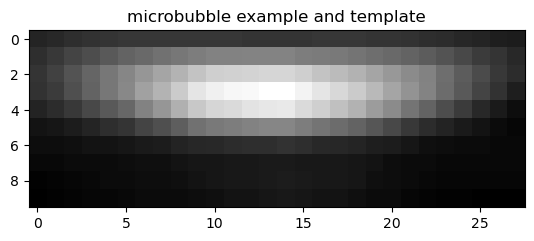

max (array([ 82,  82, 159, 159, 159, 211, 211, 211, 211, 211, 235, 235, 235,
       235, 243, 243, 244, 244, 244, 244, 250, 250, 250, 250, 250, 257,
       257, 257, 257, 257, 277, 277, 277, 279, 280, 280, 280, 288, 288,
       288, 288, 288, 289, 294, 294, 294, 361, 361, 361, 410, 410, 410,
       450, 450, 450, 450, 455, 455, 465, 465, 487, 506, 506, 506, 506,
       512, 516, 516, 516, 516, 516, 516, 522, 522, 522, 522, 522, 526,
       526, 535, 535, 535, 535, 564, 564], dtype=int64), array([654, 655, 743, 744, 745,  58,  59,  60,  61,  62, 429, 430, 431,
       432, 268, 269, 267, 268, 269, 270, 222, 223, 224, 225, 226, 415,
       416, 417, 418, 419, 387, 388, 389,  17,  16,  17,  18, 181, 182,
       227, 228, 229, 182, 529, 530, 531, 324, 325, 326, 520, 521, 522,
       450, 451, 452, 453, 409, 410, 329, 330, 530, 206, 207, 208, 209,
       186, 750, 751, 752, 753, 754, 755, 278, 279, 280, 281, 282, 798,
       799, 795, 796, 797, 798, 324, 325], dtype=int64))
[[82, 654, 28, 10

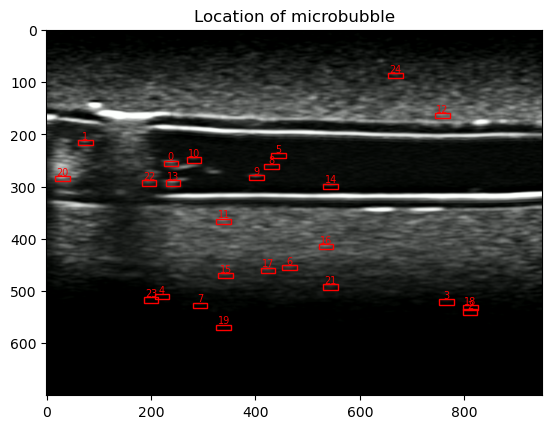

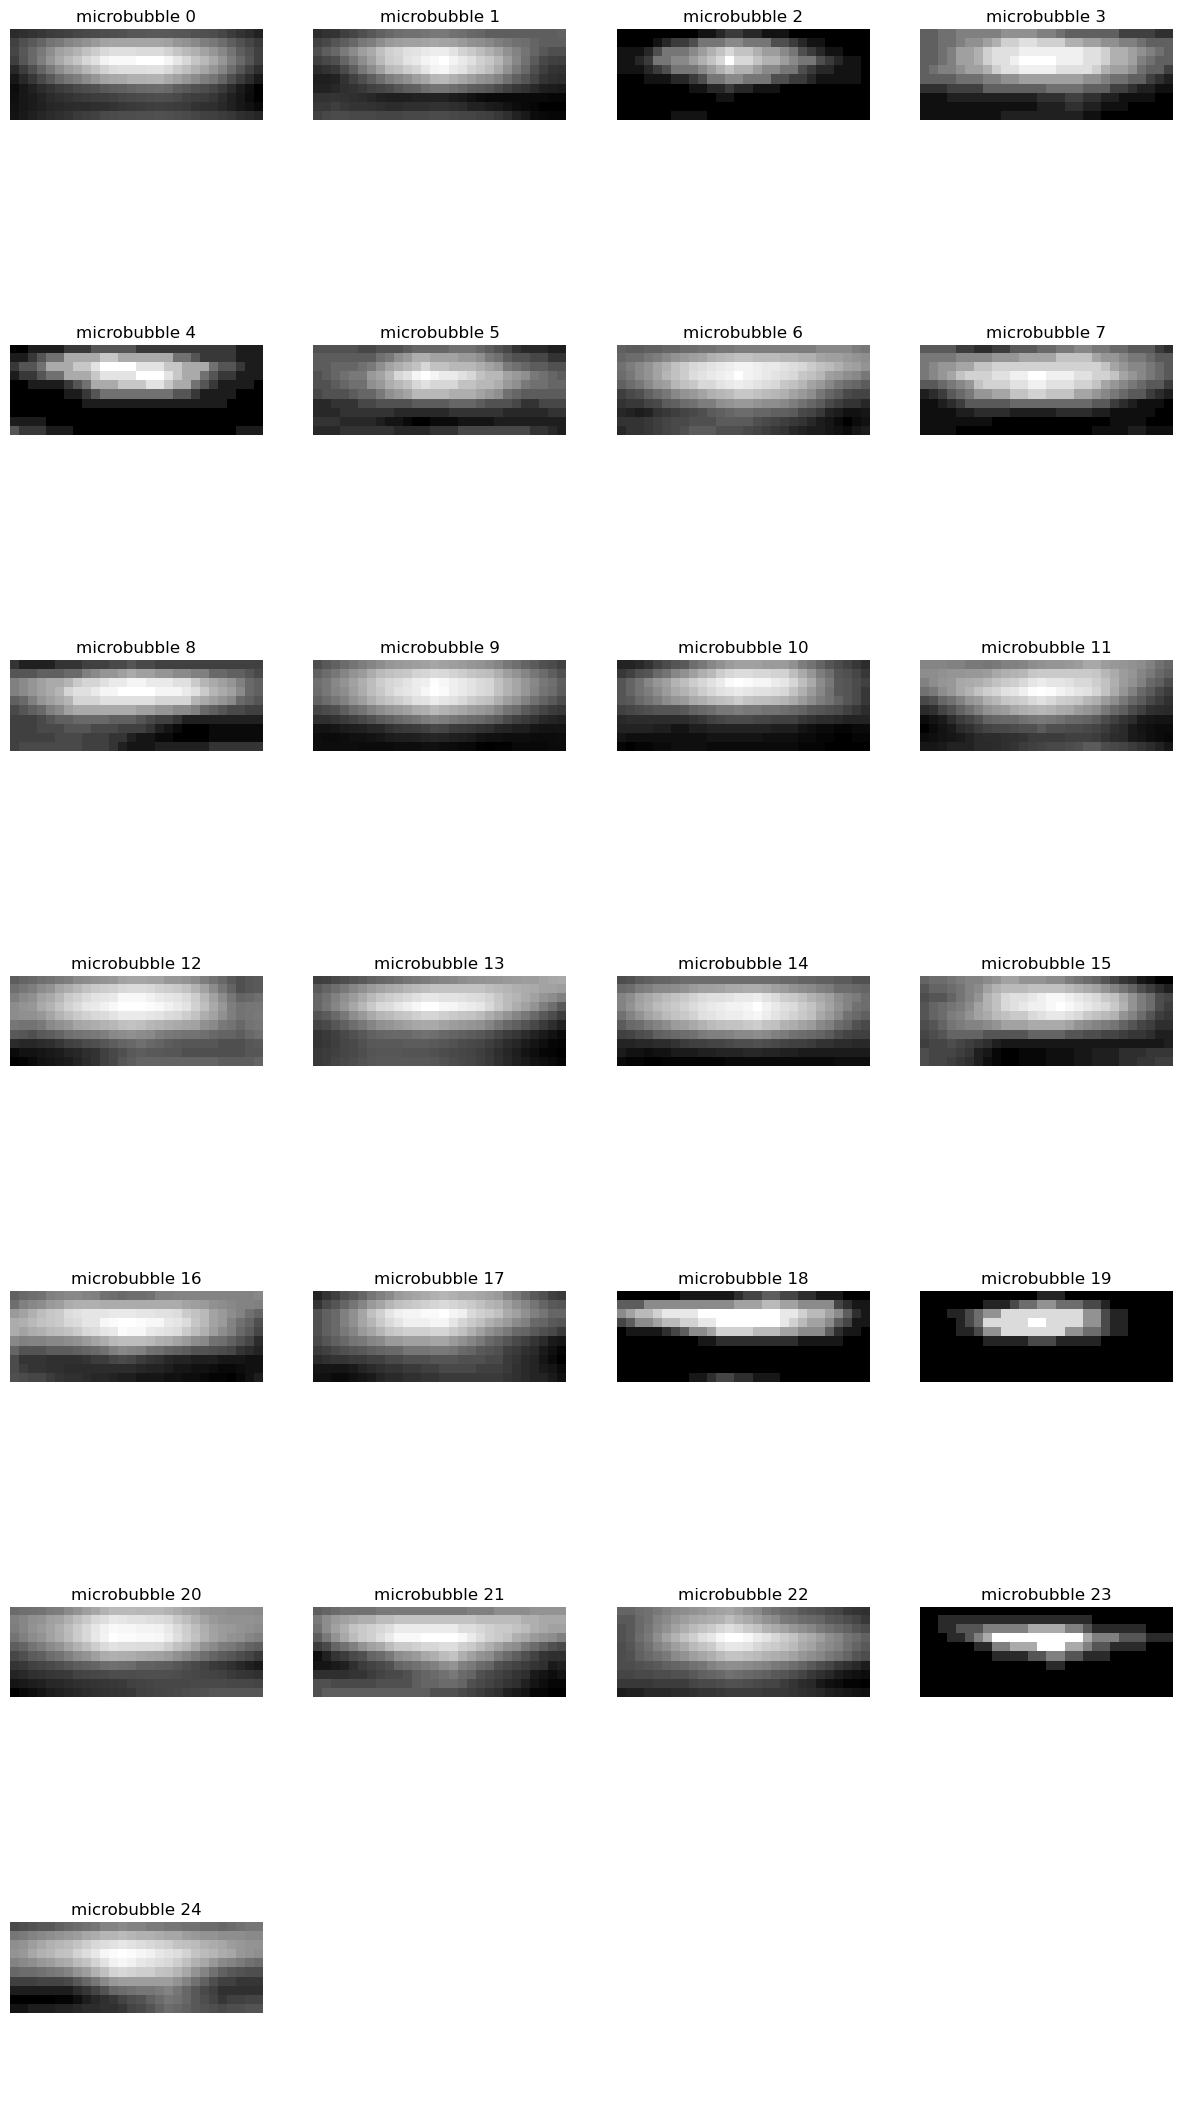

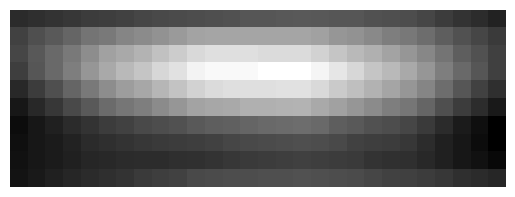

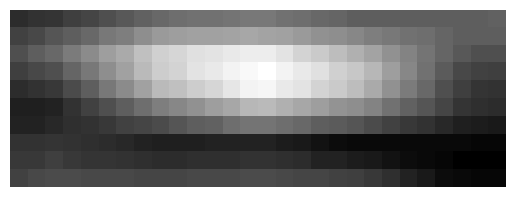

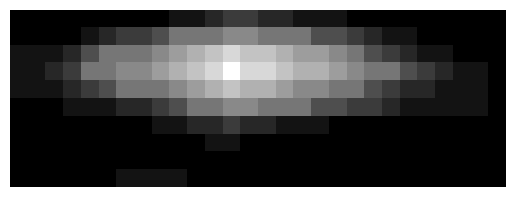

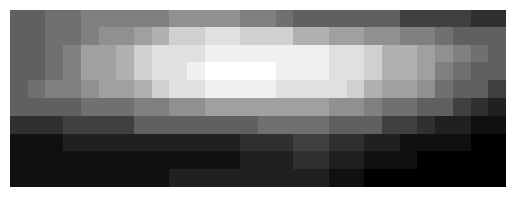

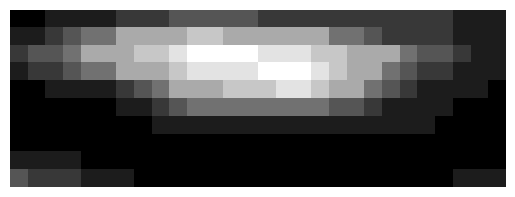

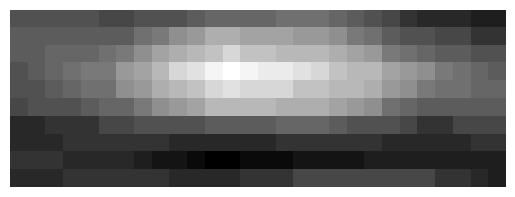

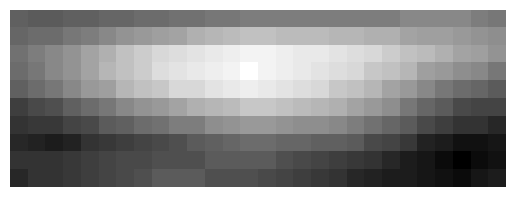

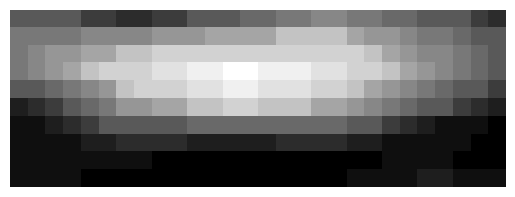

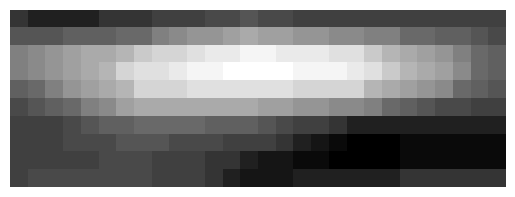

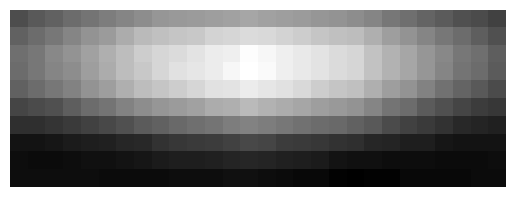

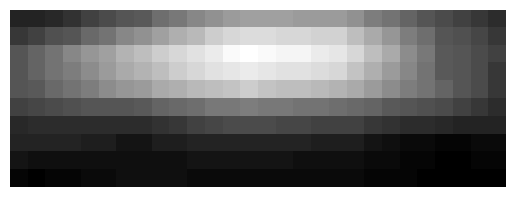

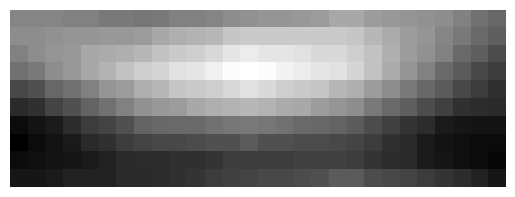

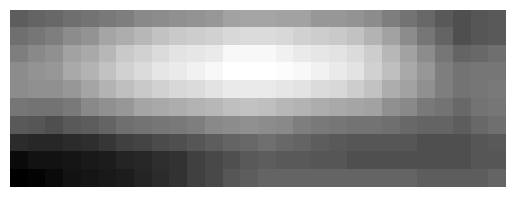

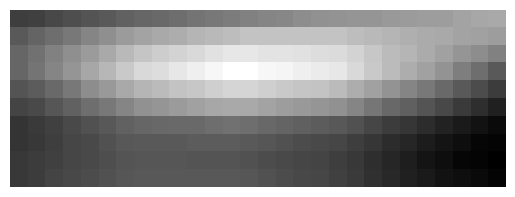

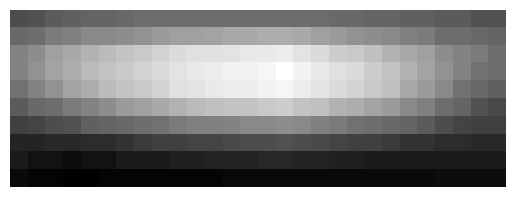

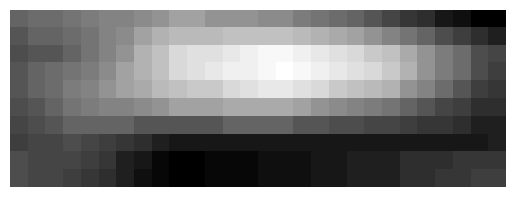

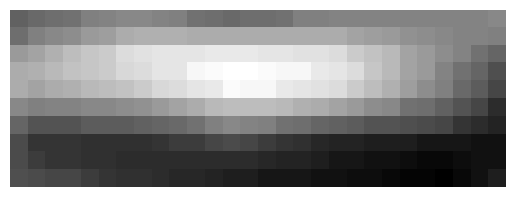

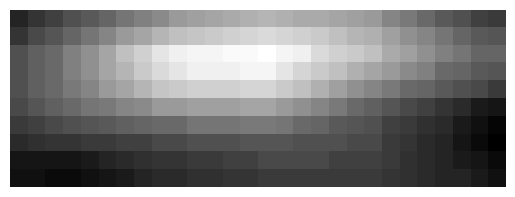

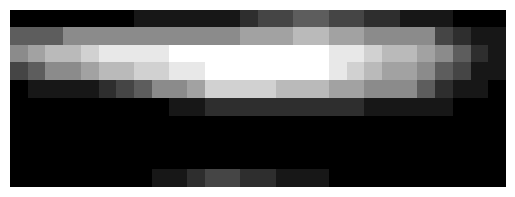

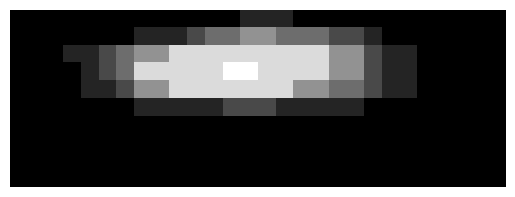

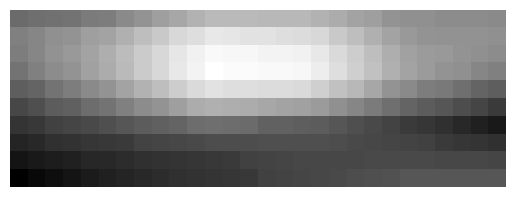

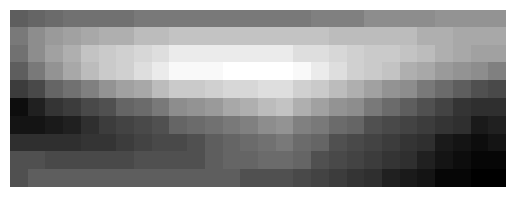

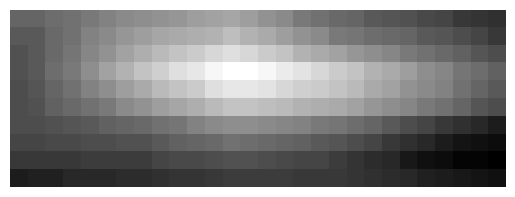

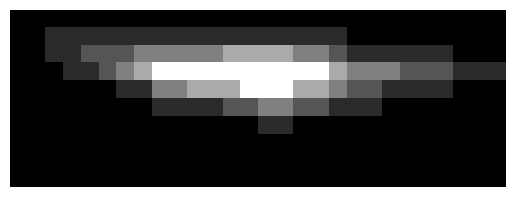

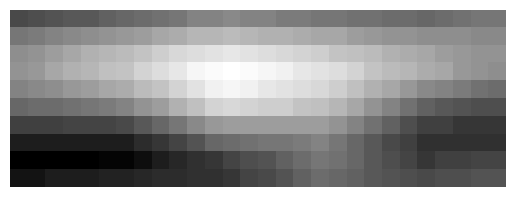

In [402]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time

# USING MODULE cv2.dnn.NMSBoxes

######################################

img_template = cv2.imread('Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png', cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.imread("Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V\\frame_0459.png")
img_rgb = cv2.imread("Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V\\frame_0459.png")
img_rgb = cv2.imread("Test videos/9th Setup Phantom Flow/2_2mL_min_2/frame_0000.png")[150:850,600:1550]
img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

template = img_template[305:315, 524:552]
w, h = template.shape[::-1]

plt.imshow(template, cmap='gray')
plt.title("microbubble example and template")
plt.show()

start_time = time.time()
res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)

# plt.imshow(res, cmap='gray')
# plt.title("result of match template")
# plt.show()

threshold = 0.90
loc = np.where( res >= threshold)
print("max", loc)


bboxes = [[i, j, w, h] for i, j in zip(loc[0], loc[1])]
scores = [res[i,j] for i, j in zip(loc[0], loc[1])]
score_threshold = 0.9
nms_threshold = 0.5
print(bboxes, scores)

indices = cv2.dnn.NMSBoxes(bboxes, scores, score_threshold, nms_threshold)#top_k: if >0, keep at most top_k picked indices.

print('indices', indices)
elapsed_time = time.time() - start_time
print('elapsed_time', elapsed_time)

fig, ax = plt.subplots()
ax.imshow(img_rgb, cmap='gray')
for i, indice in enumerate(indices):
    # cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)
    rect = patches.Rectangle((bboxes[indice][1], bboxes[indice][0]), w, h, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(bboxes[indice][1] + w / 2, bboxes[indice][0] - 7, str(i), color='r', fontsize=7, ha='center', va='center')
plt.title("Location of microbubble")
plt.show()

images_microbubbles = [img[bboxes[i][0]:bboxes[i][0]+h, bboxes[i][1]:bboxes[i][1]+w] for i in indices]
plot_microbubbles(images_microbubbles)
for i, image in enumerate(images_microbubbles):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.savefig('Report/Images/microbubble'+str(i)+'.png', bbox_inches='tight', pad_inches=0)
    plt.show()

TRACKING FELIX

In [ ]:
import cv2
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from matplotlib import patches
matplotlib.use('tkAgg')

top_left = []
bottom_right = []

def line_select_callback(clk, rls):
    print(clk.xdata, clk.ydata)
    global top_left
    global bottom_right
    top_left = (int(clk.xdata), int(clk.ydata))
    bottom_right = (int(rls.xdata), int(rls.ydata))


def onkeypress(event):
    global top_left
    global bottom_right
    global img
    if event.key == 'q':
        print('final bbox', top_left, bottom_right)
        plt.close()


def toggle_selector(event):
    toggle_selector.RS.set_active(True)

def bbox_selection():

    video_name = 'parallele_channel_1_5V_2_short'
    # video_name = 'Untitled video - Made with Clipchamp (1)'
    data_dir = 'Test videos\\4th Setup phantom_transducer\\parallele_channel_1_5V_2\\'
    # data_dir = 'C:/Users/lilap/Downloads/'
    video_path = os.path.join(data_dir, video_name + '.mp4')

    cap = cv2.VideoCapture(video_path)
  
    ret, first_image = cap.read()

    fig, ax = plt.subplots(1)
    
    first_image = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)
    ax.imshow(first_image)

    toggle_selector.RS = RectangleSelector(
            ax, line_select_callback,
            useblit=True,
            button=[1], minspanx=5, minspany=5,
            spancoords='pixels', interactive=True
        )
    
    plt.title("Draw a box then press 'q' to continue")
    plt.show()
    
    bbox_width = bottom_right[0] - top_left[0]
    bbox_height = bottom_right[1] - top_left[1]
    
    return cap, first_image, bbox_width, bbox_height, ret, video_name

def LK_Opt_Flow_tracker(cap, first_image, bbox_width, bbox_height, video_name):
    data_dir = './videos/'
    frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

    result = cv2.VideoWriter(os.path.join(data_dir, 'LK_Tracking_results_' + video_name +'.avi'), 
                         cv2.VideoWriter_fourcc(*'XVID'), 20, frame_size, True)
    
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                          qualityLevel = 0.3,
                          minDistance = 7,
                          blockSize = 7 )
    
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15, 15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    
    color = np.random.randint(0, 255, (100, 3))
    
    old_frame = first_image
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    
    mask_ = np.zeros(old_gray.shape, dtype=np.uint8)
    mask_[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = np.ones((bbox_height,bbox_width), dtype=np.uint8)
    
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = mask_, **feature_params)
    
    mask = np.zeros_like(old_frame)
    while(1):
        ret, frame = cap.read()
        if not ret:
            print('No frames grabbed!')
            break
        
        
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        
        # Select good points
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]
        # draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
        img = cv2.add(frame, mask)
        
        cv2.imshow('Tracking', img)
        cv2.waitKey(30) 

        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
        
        result.write(img)
    
    result.release()
    cv2.destroyAllWindows()

def CSRT_Tracker(cap, first_image, bbox_width, bbox_height, ret, video_name):
    data_dir = './videos/'
    tracker = cv2.legacy.TrackerCSRT_create()
    
    frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    output = cv2.VideoWriter(os.path.join(data_dir, 'CRST_Tracking_results_'+ video_name +'.avi'), 
                         cv2.VideoWriter_fourcc(*'XVID'), 20, frame_size, True)
    
    ret = tracker.init(first_image, [top_left[0], top_left[1], bbox_width, bbox_height])
    
    
    while True:
        
        ret, frame = cap.read()
        if not ret:
            print('something went wrong')
            break
            
        ret, bbox = tracker.update(frame)
        
        if ret:
            p1 = (int(bbox[0]), int(bbox[1]))
            p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
        
        else:
            cv2.putText(frame, "Tracking failure detected", (100,80), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
    
        cv2.imshow("Tracking", frame)
        output.write(frame)
        
        if cv2.waitKey(10) & 0xff == ord('s'):
            break
        

    cap.release()
    output.release()
    cv2.destroyAllWindows()
    
def MedianFLow_Tracker(cap, first_image, bbox_width, bbox_height, ret, video_name):
    data_dir = './videos/'
    tracker = cv2.legacy.TrackerMedianFlow_create() 
    
    frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    output = cv2.VideoWriter(os.path.join(data_dir, 'MedianFLow_Tracking_result_'+ video_name +'.avi'), 
                         cv2.VideoWriter_fourcc(*'XVID'), 20, frame_size, True)
    
    ret = tracker.init(first_image, [top_left[0], top_left[1], bbox_width, bbox_height])
    
    
    while True:
        
        ret, frame = cap.read()
        if not ret:
            print('something went wrong')
            break
            
        ret, bbox = tracker.update(frame)
        
        if ret:
            p1 = (int(bbox[0]), int(bbox[1]))
            p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
        
        else:
            cv2.putText(frame, "Tracking failure detected", (100,80), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
    
        cv2.imshow("Tracking", frame)
        output.write(frame)
        
        if cv2.waitKey(10) & 0xff == ord('s'):
            break
        

    cap.release()
    output.release()
    cv2.destroyAllWindows()
    
def KCF_Tracker(cap, first_image, bbox_width, bbox_height, ret, video_name):
    tracker = cv2.TrackerKCF_create()
    data_dir = './videos/'
    
    frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    output = cv2.VideoWriter(os.path.join(data_dir, 'KCF_Tracking_results_'+ video_name +'.avi'), 
                         cv2.VideoWriter_fourcc(*'XVID'), 60, frame_size, True)
    
    ret = tracker.init(first_image, [top_left[0], top_left[1], bbox_width, bbox_height])
    
    
    while True:
        
        ret, frame = cap.read()
        if not ret:
            print('something went wrong')
            break
            
        ret, bbox = tracker.update(frame)
        
        if ret:
            p1 = (int(bbox[0]), int(bbox[1]))
            p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
        
        else:
            cv2.putText(frame, "Tracking failure detected", (100,80), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
    
        cv2.imshow("Tracking", frame)
        output.write(frame)
        
        if cv2.waitKey(10) & 0xff == ord('s'):
            break
        

    cap.release()
    output.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    cap, first_image, bbox_width, bbox_height, ret, video_name = bbox_selection()
    # MedianFLow_Tracker(cap, first_image, bbox_width, bbox_height, ret, video_name)
    CSRT_Tracker(cap, first_image, bbox_width, bbox_height, ret, video_name)
    # KCF_Tracker(cap, first_image, bbox_width, bbox_height, ret, video_name)
    # LK_Opt_Flow_tracker(cap, first_image, bbox_width, bbox_height, video_name)

1086.8423517169613 417.3272632674299
something went wrong


In [ ]:
import cv2
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from matplotlib import patches
matplotlib.use('tkAgg')
import time

def bbox_selection():

    # video_name = 'parallele_channel_1_5V_2_short'
    video_name = '2_transducer_1_5V_2'
    # data_dir = 'Test videos\\4th Setup phantom_transducer\\parallele_channel_1_5V_2\\'
    data_dir = 'Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\'
    video_path = os.path.join(data_dir, video_name + '.avi')

    cap = cv2.VideoCapture(video_path)
    ret, first_image = cap.read()
    first_image = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)

    boxes = []
    for _ in range(2):
        boxes.append(cv2.selectROI("first_image", first_image, fromCenter=False,
                showCrosshair=True))
    print(boxes)
    return cap, first_image, boxes, ret, video_name

def CSRT_Tracker(cap, first_image, boxes, ret, video_name):
    data_dir = './videos/'
    trackers = cv2.legacy.MultiTracker()
    for box in boxes:
        # trackers.add(cv2.legacy.TrackerCSRT_create(), first_image, box)
        trackers.add(cv2.legacy.TrackerCSRT_create(), first_image, box)

    
    frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    output = cv2.VideoWriter(os.path.join(data_dir, 'CRST_Tracking_results_'+ video_name +'.avi'), 
                         cv2.VideoWriter_fourcc(*'XVID'), 20, frame_size, True)
    
    # ret = trackers.init(first_image, [top_left[0], top_left[1], bbox_width, bbox_height])
    
    # Start the stopwatch
    start_time = time.time()

    while True:
        
        ret, frame = cap.read()
        if not ret:
            print('something went wrong')
            break
            
        ret, boxes = trackers.update(frame)
        
        if ret:
            # loop over the bounding boxes and draw then on the frame
            for box in boxes:
                (x, y, w, h) = [int(v) for v in box]
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        else:
            cv2.putText(frame, "Tracking failure detected", (100,80), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
    
        cv2.imshow("Tracking", frame)
        output.write(frame)

        # Calculate elapsed time since the last frame
        elapsed_time = time.time() - start_time

         # Print the elapsed time
        # print(f"Elapsed Time: {elapsed_time:.2f} seconds")

        # Update the start time for the next frame
        start_time = time.time()

        if cv2.waitKey(10) & 0xff == ord('s'):
            break
        

    cap.release()
    output.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    cap, first_image, boxes, ret, video_name = bbox_selection()
    # MedianFLow_Tracker(cap, first_image, bbox_width, bbox_height, ret, video_name)
    CSRT_Tracker(cap, first_image, boxes, ret, video_name)
    # KCF_Tracker(cap, first_image, bbox_width, bbox_height, ret, video_name)
    # LK_Opt_Flow_tracker(cap, first_image, bbox_width, bbox_height, video_name)

[(547, 288, 26, 14), (525, 303, 30, 9)]


AttributeError: module 'cv2.legacy' has no attribute 'MultiTracker'

YOLO TRACKER

In [ ]:
from collections import defaultdict

import cv2
import numpy as np

from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')

# Open the video file
video_path = "Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\2_transducer_1_5V_2.avi"
cap = cv2.VideoCapture(0)

# Store the track history
track_history = defaultdict(lambda: [])

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model.track(frame, persist=True)
        # print(results)
        for result in results:
            if result.boxes is None or result.boxes.id is None:
                continue
            # Get the boxes and track IDs
            else:
                boxes = result.boxes.xywh.cpu()
                track_ids = result.boxes.id.cpu().numpy().astype(int)

                # Visualize the results on the frame
                annotated_frame = result.plot()

                # Plot the tracks
                for box, track_id in zip(boxes, track_ids):
                    x, y, w, h = box
                    track = track_history[track_id]
                    track.append((float(x), float(y)))  # x, y center point
                    if len(track) > 30:  # retain 90 tracks for 90 frames
                        track.pop(0)

                    # Draw the tracking lines
                    points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                    cv2.polylines(annotated_frame, [points], isClosed=False, color=(0, 255, 0), thickness=10)

                # Display the annotated frame
                cv2.imshow("YOLOv8 Tracking", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


0: 480x640 3 persons, 1 cat, 1 dog, 2 couchs, 1 potted plant, 110.5ms
Speed: 0.0ms preprocess, 110.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 persons, 1 cat, 1 dog, 2 couchs, 1 potted plant, 1 bed, 101.1ms
Speed: 2.4ms preprocess, 101.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 persons, 1 giraffe, 3 couchs, 1 potted plant, 1 bed, 102.2ms
Speed: 1.7ms preprocess, 102.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 persons, 1 cat, 1 dog, 3 couchs, 2 potted plants, 1 bed, 101.2ms
Speed: 2.0ms preprocess, 101.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 persons, 1 cat, 1 dog, 1 giraffe, 3 couchs, 3 potted plants, 1 bed, 100.8ms
Speed: 1.8ms preprocess, 100.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 persons, 1 cat, 1 dog, 3 couchs, 3 potted plants, 1 bed, 108.2ms
Speed: 2.2ms preprocess, 108.2ms infer

SORT

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import match_template
import numpy as np

def get_video_info(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        raise ValueError("Error: Could not open the video file.")

    # Get the frame width and frame height
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    return cap, frame_width, frame_height


def find_max_values_with_distance(data, num_values, min_distance):
    array_data = np.array(data)
    max_indices = []

    for _ in range(num_values):
        # Find the index of the maximum value
        flat_indices = np.argmax(array_data)
        index_2d = np.unravel_index(flat_indices, array_data.shape)

        # Add the index to the result
        max_indices.append(index_2d)

        # Set the neighborhood around the selected index to zero
        neighborhood = slice(index_2d[0] - min_distance, index_2d[0] + min_distance + 1), \
                       slice(index_2d[1] - min_distance, index_2d[1] + min_distance + 1)
        array_data[neighborhood] = 0
    
    # Convert the list of tuples to a tuple containing two arrays
    indices_2d = tuple(np.array(x) for x in zip(*max_indices))

    return indices_2d

def detection(img_template, img):
    template = img_template[305:315, 524:552]

    result = match_template(img, template)

    num_values = 10
    min_distance = 5
    indices_2d = find_max_values_with_distance(result, num_values, min_distance)
    x_, y_ = indices_2d[::-1]

    boxes = [[x_[i], y_[i]-5, x_[i]+20, y_[i]+10, 1] for i in range(len(x_))]
    return np.array(boxes)

def draw_boxes(img, bbox):
    # convert to 3 channel black (color)
    img = cv2.merge([img,img,img])
    
    for i, box in enumerate(bbox):
        x1, y1,  x2, y2,  id = [int(i) for i in box]       
        #Create Bounding Boxes around the Detected Objects
        cv2.rectangle(img, (x1, y1), (x2, y2),color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
        label = "Microbubble" #+ str(id)
        #Create a rectangle above the detected object and add label and confidence score
        t_size=cv2.getTextSize(str(label), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1/4, thickness=1)[0]
        c2=x1+t_size[0], y1-t_size[1]-3
        cv2.rectangle(img, (x1, y1), c2, color=(0, 0, 255), thickness=-1, lineType=cv2.LINE_AA)
        cv2.putText(img, str(label), (x1, y1-2), 0, 1/4, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)
        
    return img

In [ ]:
import sys
sys.path.append("sort-master")
from sort import *

img_template = cv2.imread('Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread("Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V\\frame_0459.png", cv2.IMREAD_GRAYSCALE)
# Open the video file
video_path = "Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\2_transducer_1_5V_2.avi"

cap, frame_width, frame_height = get_video_info(video_path)

# output = cv2.VideoWriter('SORT_test.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (frame_width, frame_height))
# output = cv2.VideoWriter('SORT_test.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 30, (frame_width, frame_height))

#create instance of SORT
mot_tracker = Sort() 

# Loop through the video frames
while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    # Read a frame from the video
    success, frame = cap.read()	

    if success:
        #Convert colored frame to black & white
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # get detections
        detections = detection(img_template, frame)

        # update SORT
        track_bbs_ids = mot_tracker.update(detections)

        annotated_frame = draw_boxes(frame, track_bbs_ids)
        # Display the annotated frame
        cv2.imshow("SORT Tracking", annotated_frame)
        # output.write(annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
# output.release()
cap.release()
cv2.destroyAllWindows()

ELLIPSE DETECTION

In [ ]:
import matplotlib.pyplot as plt
import cv2

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Load picture, convert to grayscale and detect edges
image_gray = cv2.imread('Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png', cv2.IMREAD_GRAYSCALE)

edges = canny(image_gray, sigma=2.0,
              low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=100, max_size=120)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = (int(round(x)) for x in best[1:5])
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_gray[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(image_gray)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()

KeyboardInterrupt: 

In [ ]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import random as rng
rng.seed(12345)
def thresh_callback(val):
    threshold = val
    
    canny_output = cv.Canny(src_gray, threshold, threshold * 2)
    cv.imshow('canny_output', canny_output)
    
    contours, _ = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    # Find the rotated rectangles and ellipses for each contour
    minRect = [None]*len(contours)
    minEllipse = [None]*len(contours)
    for i, c in enumerate(contours):
        minRect[i] = cv.minAreaRect(c)
        if c.shape[0] > 5:
            minEllipse[i] = cv.fitEllipse(c)
    # Draw contours + rotated rects + ellipses
    
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    
    for i, c in enumerate(contours):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        # contour
        cv.drawContours(drawing, contours, i, color)
        # ellipse
        if c.shape[0] > 5:
            cv.ellipse(drawing, minEllipse[i], color, 2)
        # rotated rectangle
        box = cv.boxPoints(minRect[i])
        box = np.intp(box) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
        cv.drawContours(drawing, [box], 0, color)
    
    
    cv.imshow('Contours', drawing)
    
src = cv.imread('Test videos\\4th Setup phantom_transducer\\2_transducer_1_5V_2\\frame_0000.png')

src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
src_gray = cv.blur(src_gray, (3,3))
source_window = 'Source'
cv.namedWindow(source_window)
cv.imshow(source_window, src)
max_thresh = 255
thresh = 100 # initial threshold
cv.createTrackbar('Canny Thresh:', source_window, thresh, max_thresh, thresh_callback)
thresh_callback(thresh)

# canny_output = cv.Canny(src_gray, thresh, thresh * 2)
# cv.imshow('canny_output', canny_output)
cv.waitKey()

-1

PASS THROUGH FRAMES WITH RIGHT ARROW

In [1]:
import cv2

def get_number_of_frames(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return -1

    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    cap.release()

    return num_frames

# Example usage:
video_path = "test_camera_app.mp4"
video_path = "Report\Images\Deepsort_9_2_2mL_min_2_newnew.mp4"
num_frames = get_number_of_frames(video_path)

if num_frames != -1:
    print(f"Number of frames in the video: {num_frames}")


Number of frames in the video: 393


In [6]:
import cv2

def display_frames(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while True:
        ret, frame = cap.read()

        if not ret:
            print("End of video.")
            break

        cv2.imshow("Frame", frame)

        # Wait for the right arrow key (key code 2555904) to be pressed
        key = cv2.waitKey(0)
        if key == 2555904:
            continue
        elif key == 27:  # Break the loop if the 'Esc' key is pressed
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
video_path = "test_camera_app.mp4"  # Replace with the actual path to your video
video_path = "Presentation\Images\Deepsort_9_2_2mL_min_2.mp4"
video_path = "Report\Images\Deepsort_9_2_2mL_min_2_newnew.mp4"
display_frames(video_path)


End of video.


CALCUL FREQUENCY    

In [218]:
import numpy as np
gamma = 1.4 #polytrope coefficient of the enclosed gas
pa = 100 #Ambient pressure
rho = 1 #Water density
alpha = 5e-6   #Radius of microbubble

f = pow(3*gamma*pa/rho, 0.5)/(2*np.pi*alpha)

f_="{:e}".format(f)
print("frequency = ", f_, "Hz")

frequency =  6.523411e+05 Hz
